In [1]:
import pandas as pd 
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from scipy.stats import mannwhitneyu
import glob
import os
from scipy.stats import chi2_contingency

In [2]:
# Manually select files
df= pd.read_csv('/Users/elliehe/Desktop/OneDrive/NBB495B/excel_raw_data/AP36/AP36_M1_M2_one_timing.csv')

In [3]:
#Define all variables:
values_to_format = {
    # Values to loop through in the "TrialTypes" column
    "TrialTypes":{0: "Right Side Trials", 1: "Left Side Trials"},

    # Values to loop through in the "OptoState" column
    "OptoState":{0: "Non-opto trials", 1: "Opto trials"},

    # Values to loop through in the "IDOptoLoc" column
    "IDOptoLoc":{1:"Non-opto", 2: "Opto during Delay Period", 3: "Opto during Response Period", 4:"Opto in Consumption Period"},

    # Values to loop through in the "OptoEI" column
    "OptoEI":{0:"Non-opto", 1: "Excitation", 2: "Inhibition"},

    # Values to loop through in the "Outcome" column
    "Outcome":{0: "Wrong Side Reach", 1: "Correct", 3: "No Response"}
}

In [4]:
# replace the values in the corresponding columns
for col, vals in values_to_format.items():
    df[col] = df[col].replace(vals).astype('category')

In [5]:
# drop these values to select opto trials
df.drop(df[
    (df["OptoState"] != "Non-opto trials") & \
    (df["IDOptoLoc"].isin(["Non-opto", "Opto in Consumption Period"]) | df["OptoEI"].isin(["Non-opto"]))].index,
        inplace=True)

In [6]:
# create a column with reaction times either left or right,
# depending on the value of Outcome, which must be "Correct"
# and the value of the column TrialTypes

def _get_RT(x):
    if x["Outcome"] != "Correct":
        return np.nan
    elif x["TrialTypes"] == "Left Side Trials":
        return x["RT_Left"]
    elif x["TrialTypes"] == "Right Side Trials":
        return x["RT_Right"]
    else:
        raise Exception()
        

df["RT"] = df.apply(lambda x : _get_RT(x), axis=1)

In [7]:
def _get_outcome(filtered_df):
    # Count occurrences of each value in the "Outcome" column
    count = filtered_df["Outcome"].value_counts()
        
    # Calculate the average rate
    average_rate = count / len(filtered_df)
    
    # merge the two columns
    outcome_counts = pd.concat([count, average_rate], axis=1).sort_index().reset_index()
    
    # rename the columns
    outcome_counts.columns = [ "Outcome", "Count", "Average Rate" ]
    
    # it avoids to generate an error in the case no "Correct" trial has occured
    if outcome_counts["Outcome"].isin(["Correct"]).any():
        # retain all the outcomes which are one
        rt_mean = filtered_df.loc[filtered_df["Outcome"] == "Correct", "RT"].mean()
        rt_std = filtered_df.loc[filtered_df["Outcome"] == "Correct", "RT"].std()
        rt_n = len(filtered_df.loc[filtered_df["Outcome"] == "Correct", "RT"])  
        
        outcome_counts.loc[outcome_counts["Outcome"] == "Correct", "RT mean"] = rt_mean 
        outcome_counts.loc[outcome_counts["Outcome"] == "Correct", "RT std"] = rt_std
        outcome_counts.loc[outcome_counts["Outcome"] == "Correct", "RT n"] = rt_n     

    return outcome_counts

In [8]:
all_outcomes = []

for (Week_Age_value, Location_value, TrialTypes_value, OptoState_value), filtered_df in df.groupby(["Week_Age", "Location", "TrialTypes", "OptoState"]):
    print(f"\nWeek Age: {Week_Age_value}, Location: {Location_value}\nTrialTypes: {TrialTypes_value}, OptoState: {OptoState_value}")
    
    if OptoState_value == "Non-opto trials":
        outcome = _get_outcome(filtered_df)
            
        print(outcome)
        
            
        outcome["Week_Age"] = Week_Age_value
        outcome["Location"] = Location_value
        outcome["TrialTypes"] = TrialTypes_value
        outcome["OptoState"] = OptoState_value
        
        # merge all the outcome data structure for future concatenation
        all_outcomes.append(outcome)        
    else:
         # Calculate and print the total count for the current "IDOptoLoc" value within the "OptoState" filter
        
        print("Total Counts #1:")
        print(filtered_df["IDOptoLoc"].value_counts())
        print()
        print("Total Counts #2:")        
        print(filtered_df[["IDOptoLoc", "OptoEI"]].value_counts())
        print()
        
        for (IDOptoLoc_value, OptoEI_value), filtered_df_2 in filtered_df.groupby(["IDOptoLoc", "OptoEI"]):
            print(f"IDOptoLoc: {IDOptoLoc_value}\nOptoEI: {OptoEI_value}")
            outcome = _get_outcome(filtered_df_2)
            
            print(outcome)
            
            outcome["Week_Age"] = Week_Age_value
            outcome["Location"] = Location_value
            outcome["TrialTypes"] = TrialTypes_value
            outcome["OptoState"] = OptoState_value
            outcome["IDOptoLoc"] = IDOptoLoc_value
            outcome["OptoEI"] = OptoEI_value
            
            # merge all the outcome data structure for future concatenation
            all_outcomes.append(outcome)
    print()
    
# concatenate, it turns the of dataframe to a single dataframe
all_outcomes = pd.concat(all_outcomes, ignore_index=True)


Week Age: 29, Location: M1
TrialTypes: Left Side Trials, OptoState: Non-opto trials
            Outcome  Count  Average Rate   RT mean    RT std  RT n
0           Correct     33      0.891892  0.376285  0.227125  33.0
1       No Response      4      0.108108       NaN       NaN   NaN
2  Wrong Side Reach      0      0.000000       NaN       NaN   NaN


Week Age: 29, Location: M1
TrialTypes: Left Side Trials, OptoState: Opto trials
Total Counts #1:
Opto during Delay Period    23
Name: IDOptoLoc, dtype: int64

Total Counts #2:
IDOptoLoc                 OptoEI    
Opto during Delay Period  Excitation    12
                          Inhibition    11
dtype: int64

IDOptoLoc: Opto during Delay Period
OptoEI: Excitation
            Outcome  Count  Average Rate   RT mean    RT std  RT n
0           Correct     11      0.916667  0.658818  0.329863  11.0
1       No Response      1      0.083333       NaN       NaN   NaN
2  Wrong Side Reach      0      0.000000       NaN       NaN   NaN
IDOptoLoc

            Outcome  Count  Average Rate   RT mean    RT std  RT n
0           Correct     13           1.0  0.390408  0.326331  13.0
1       No Response      0           0.0       NaN       NaN   NaN
2  Wrong Side Reach      0           0.0       NaN       NaN   NaN
IDOptoLoc: Opto during Delay Period
OptoEI: Inhibition
            Outcome  Count  Average Rate  RT mean    RT std  RT n
0           Correct     14         0.875    0.186  0.081506  14.0
1       No Response      0         0.000      NaN       NaN   NaN
2  Wrong Side Reach      2         0.125      NaN       NaN   NaN


Week Age: 32, Location: M2
TrialTypes: Right Side Trials, OptoState: Non-opto trials
            Outcome  Count  Average Rate  RT mean    RT std  RT n
0           Correct     20      0.344828  0.67911  0.194305  20.0
1       No Response      4      0.068966      NaN       NaN   NaN
2  Wrong Side Reach     34      0.586207      NaN       NaN   NaN


Week Age: 32, Location: M2
TrialTypes: Right Side Trials, Op

In [9]:
all_outcomes

,Outcome,Count,Average Rate,RT mean,RT std,RT n,Week_Age,Location,TrialTypes,OptoState,IDOptoLoc,OptoEI
0,Correct,33,0.891892,0.376285,0.227125,33.0,29,M1,Left Side Trials,Non-opto trials,NaN,NaN
1,No Response,4,0.108108,NaN,NaN,NaN,29,M1,Left Side Trials,Non-opto trials,NaN,NaN
2,Wrong Side Reach,0,0.000000,NaN,NaN,NaN,29,M1,Left Side Trials,Non-opto trials,NaN,NaN
3,Correct,11,0.916667,0.658818,0.329863,11.0,29,M1,Left Side Trials,Opto trials,Opto during Delay Period,Excitation
4,No Response,1,0.083333,NaN,NaN,NaN,29,M1,Left Side Trials,Opto trials,Opto during Delay Period,Excitation
...,...,...,...,...,...,...,...,...,...,...,...,...
103,No Response,2,0.142857,NaN,NaN,NaN,32,M2,Right Side Trials,Opto trials,Opto during Delay Period,Excitation
104,Wrong Side Reach,7,0.500000,NaN,NaN,NaN,32,M2,Right Side Trials,Opto trials,Opto during Delay Period,Excitation
105,Correct,2,0.200000,0.783250,0.139088,2.0,32,M2,Right Side Trials,Opto trials,Opto during Delay Period,Inhibition
106,No Response,1,0.100000,NaN,NaN,NaN,32,M2,Right Side Trials,Opto trials,Opto during Delay Period,Inhibition


In [10]:
# replace all the null values in these columns with "Non-opto" 
all_outcomes["OptoEI"] = all_outcomes["OptoEI"].replace(np.nan, "Non-opto")
all_outcomes["IDOptoLoc"] = all_outcomes["IDOptoLoc"].replace(np.nan, "Non-opto")

In [11]:
all_outcomes

,Outcome,Count,Average Rate,RT mean,RT std,RT n,Week_Age,Location,TrialTypes,OptoState,IDOptoLoc,OptoEI
0,Correct,33,0.891892,0.376285,0.227125,33.0,29,M1,Left Side Trials,Non-opto trials,Non-opto,Non-opto
1,No Response,4,0.108108,NaN,NaN,NaN,29,M1,Left Side Trials,Non-opto trials,Non-opto,Non-opto
2,Wrong Side Reach,0,0.000000,NaN,NaN,NaN,29,M1,Left Side Trials,Non-opto trials,Non-opto,Non-opto
3,Correct,11,0.916667,0.658818,0.329863,11.0,29,M1,Left Side Trials,Opto trials,Opto during Delay Period,Excitation
4,No Response,1,0.083333,NaN,NaN,NaN,29,M1,Left Side Trials,Opto trials,Opto during Delay Period,Excitation
...,...,...,...,...,...,...,...,...,...,...,...,...
103,No Response,2,0.142857,NaN,NaN,NaN,32,M2,Right Side Trials,Opto trials,Opto during Delay Period,Excitation
104,Wrong Side Reach,7,0.500000,NaN,NaN,NaN,32,M2,Right Side Trials,Opto trials,Opto during Delay Period,Excitation
105,Correct,2,0.200000,0.783250,0.139088,2.0,32,M2,Right Side Trials,Opto trials,Opto during Delay Period,Inhibition
106,No Response,1,0.100000,NaN,NaN,NaN,32,M2,Right Side Trials,Opto trials,Opto during Delay Period,Inhibition


In [12]:
all_outcomes.isnull().sum()

Outcome          0
Count            0
Average Rate     0
RT mean         72
RT std          72
RT n            72
Week_Age         0
Location         0
TrialTypes       0
OptoState        0
IDOptoLoc        0
OptoEI           0
dtype: int64

In [13]:
all_outcomes.OptoEI.unique()

array(['Non-opto', 'Excitation', 'Inhibition'], dtype=object)

In [14]:
all_outcomes.Week_Age.unique()

array([29, 30, 31, 32])

In [15]:
# store into an excel file
all_outcomes.to_excel('all_outcomes_AP36_one_opto.xlsx')

# Analysis for overall opto trial outcomes (week 29-33)

In [16]:
all_outcomes = pd.read_excel('all_outcomes_AP36_one_opto.xlsx')

# success rate M1

In [17]:
success_trials_M1 = all_outcomes[(all_outcomes.Outcome == "Correct")&(all_outcomes.Location == "M1")]

In [18]:
success_trials_M1["OptoEI"].unique()

array(['Non-opto', 'Excitation', 'Inhibition'], dtype=object)

#Mitopark Mouse Average Success Rate Based on Opto Stimulation During Delay and Response Period (both left and right side)


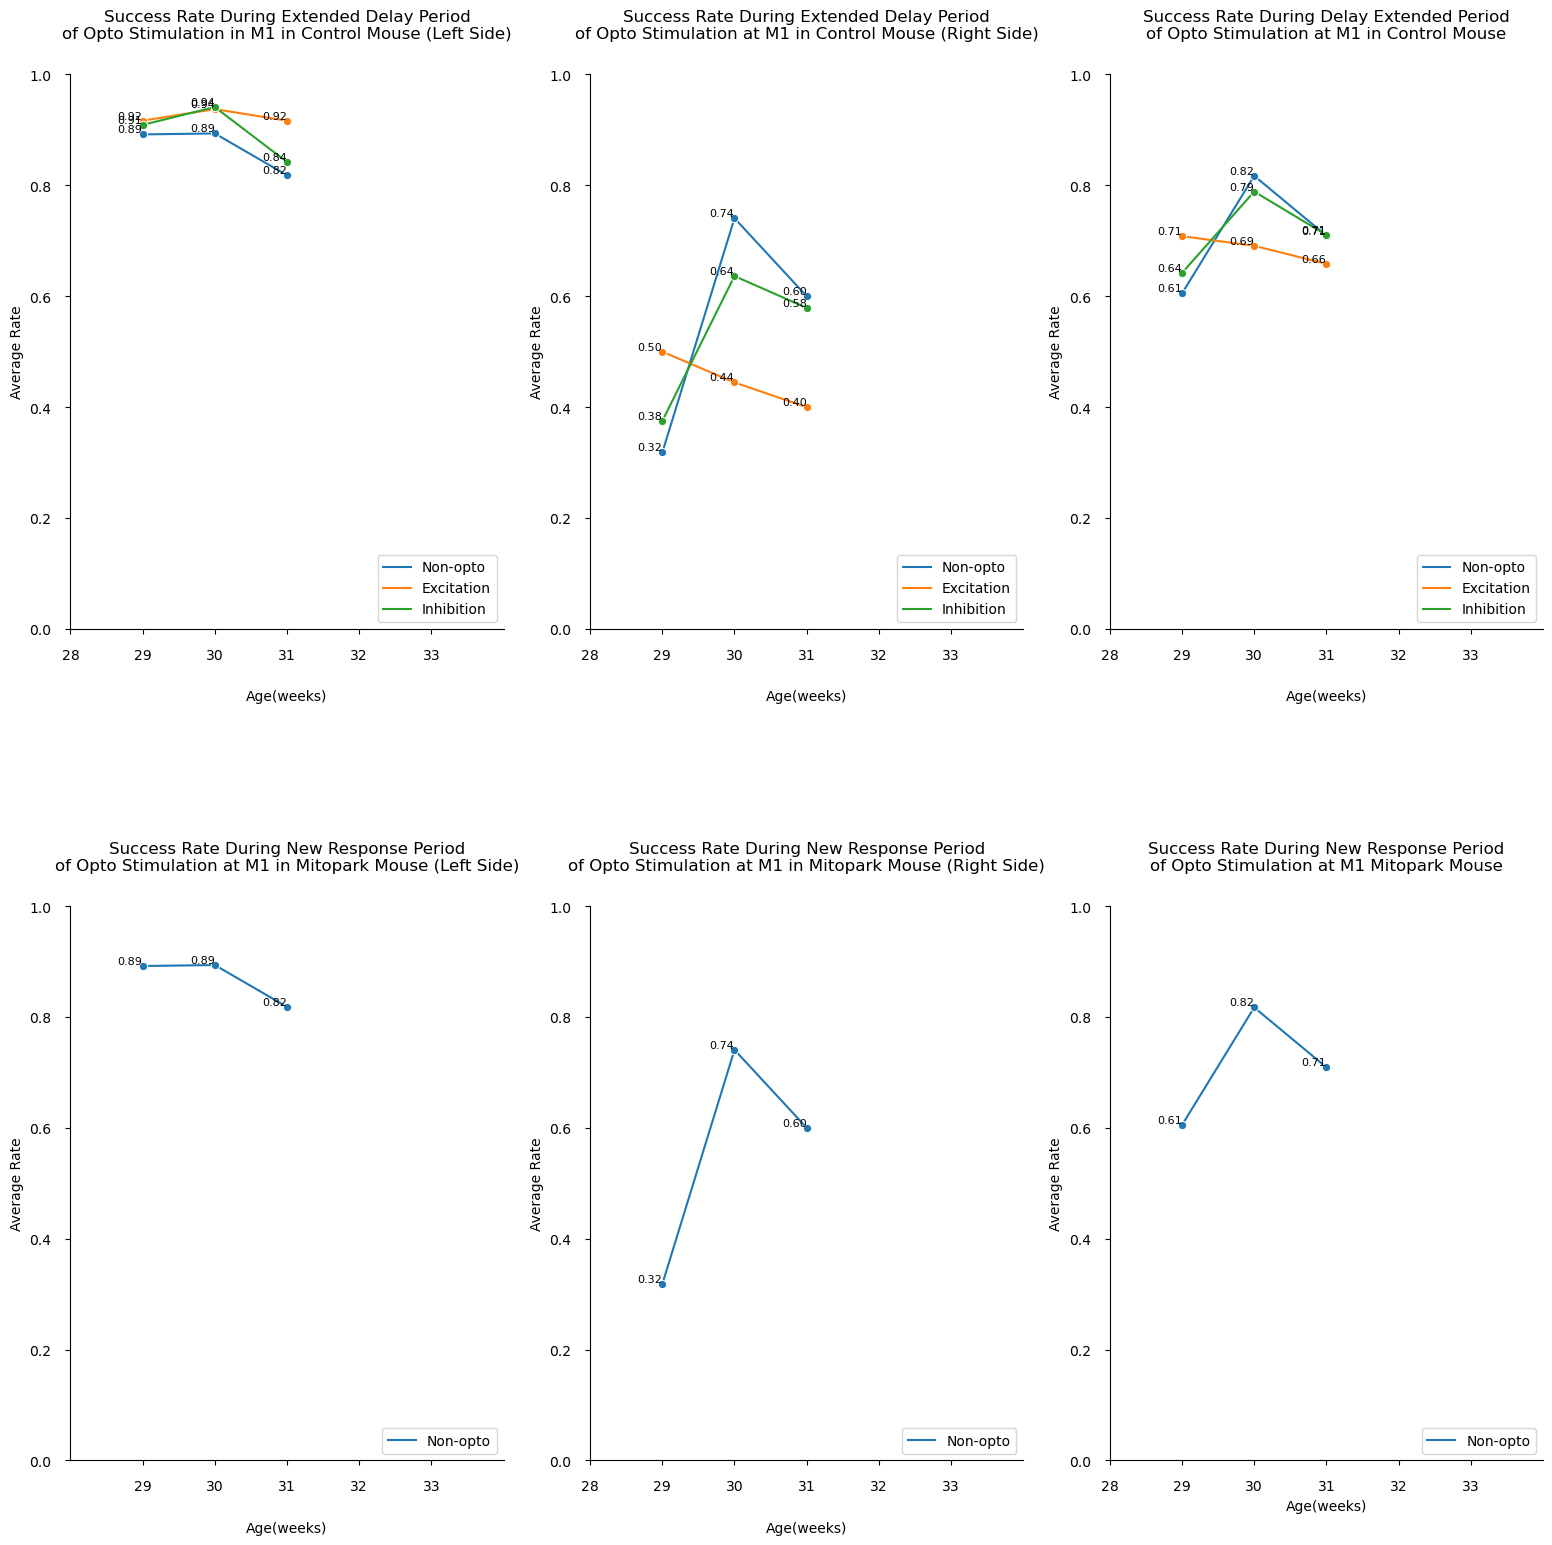

In [19]:
# Set figures to be 2x3
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(19, 18)

#Plotting the first line plot: success rate of opto during response period, by OptoEI (ax[0][0]), Left
sns.lineplot(data=success_trials_M1[
    ((success_trials_M1.IDOptoLoc == "Opto during Delay Period") & (success_trials_M1.TrialTypes == "Left Side Trials") | (success_trials_M1.IDOptoLoc == "Non-opto")) &
    (success_trials_M1.TrialTypes == "Left Side Trials")
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[0][0])

# Annotate y-values for the first subplot (0,0)
for line in ax[0][0].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[0][0].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[0][0])
ax[0][0].set_title('Success Rate During Extended Delay Period\nof Opto Stimulation in M1 in Control Mouse (Left Side)',y=1.05)
ax[0][0].set_xlabel('Age(weeks)',labelpad=20)
ax[0][0].set_xlim(28,34)  # Modify x-axis range
ax[0][0].set_xticks(range(28,34))  # Add ticks for each integer value from 19 to 29
ax[0][0].set_ylabel('Average Rate')
ax[0][0].set_xlim(28,34)  # Modify x-axis range
ax[0][0].legend(loc='lower right')
ax[0][0].set_ylim(0, 1)
ax[0][0].tick_params(axis='both', which='major', pad=10)  



#Plotting the second (0,1) line plot: success rate of opto during delay period, M1, by OptoEI, Right (ax[0][1])
sns.lineplot(data=success_trials_M1[
    ((success_trials_M1.IDOptoLoc == "Opto during Delay Period") & (success_trials_M1.TrialTypes == "Right Side Trials") | (success_trials_M1.IDOptoLoc == "Non-opto")) &
    (success_trials_M1.TrialTypes == "Right Side Trials")
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[0][1])


for line in ax[0][1].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[0][1].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[0][1])
ax[0][1].set_title('Success Rate During Extended Delay Period\nof Opto Stimulation at M1 in Control Mouse (Right Side)',y=1.05)
ax[0][1].set_xlabel('Age(weeks)',labelpad=20)
ax[0][1].set_xlim(28, 34)  # Modify x-axis range
ax[0][1].set_xticks(range(28, 34))  # Add ticks for each integer value from 19 to 29
ax[0][1].set_ylabel('Average Rate')
ax[0][1].set_xlim(28, 34)  # Modify x-axis range
ax[0][1].legend(loc='lower right')
ax[0][1].set_ylim(0, 1)
ax[0][1].tick_params(axis='both', which='major', pad=10)

#Plotting the third（0，2） line plot: success rate of opto during delay period, M1, by OptoEI, both L&R
sns.lineplot(data=success_trials_M1[
    ((success_trials_M1.IDOptoLoc == "Opto during Delay Period")| (success_trials_M1.IDOptoLoc == "Non-opto"))
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[0][2])

# Annotate y-values for the first subplot
for line in ax[0][2].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[0][2].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[0][2])
ax[0][2].set_title('Success Rate During Delay Extended Period\nof Opto Stimulation at M1 in Control Mouse',y=1.05)
ax[0][2].set_xlabel('Age(weeks)',labelpad=20)
ax[0][2].set_xlim(28, 34)  # Modify x-axis range
ax[0][2].set_xticks(range(28, 34))  # Add ticks for each integer value from 19 to 29
ax[0][2].set_ylabel('Average Rate')
ax[0][2].set_xlim(28, 34)  # Modify x-axis range
ax[0][2].legend(loc='lower right')
ax[0][2].set_ylim(0, 1)
ax[0][2].tick_params(axis='both', which='major', pad=10)  


#Plotting the fourth (1,0) line plot: success rate of opto during response period, M1, by OptoEI, Left (ax[1][0])
sns.lineplot(data=success_trials_M1[
    ((success_trials_M1.IDOptoLoc == "Opto during Response Period") & (success_trials_M1.TrialTypes == "Left Side Trials") | (success_trials_M1.IDOptoLoc == "Non-opto")) &
    (success_trials_M1.TrialTypes == "Left Side Trials")
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[1][0])

for line in ax[1][0].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[1][0].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[1][0])
ax[1][0].set_title('Success Rate During New Response Period\nof Opto Stimulation at M1 in Mitopark Mouse (Left Side)',y=1.05)
ax[1][0].set_xlabel('Age(weeks)',labelpad=20)
ax[1][0].set_xlim(28, 34)  # Modify x-axis range
ax[1][0].set_xticks(range(29, 34))  # Add ticks for each integer value from 19 to 29
ax[1][0].set_ylabel('Average Rate')
ax[1][0].set_xlim(28, 34)  # Modify x-axis range
ax[1][0].legend(loc='lower right')
ax[1][0].set_ylim(0, 1)
ax[1][0].tick_params(axis='both', which='major', pad=10)  
#Plotting the fifth line plot: success rate of opto during response period, M1, by OptoEI, Right (ax[0][1])
sns.lineplot(data=success_trials_M1[
    ((success_trials_M1.IDOptoLoc == "Opto during Response Period") & (success_trials_M1.TrialTypes == "Right Side Trials") | (success_trials_M1.IDOptoLoc == "Non-opto")) &
    (success_trials_M1.TrialTypes == "Right Side Trials")
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[1][1])


for line in ax[1][1].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[1][1].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[1][1])
ax[1][1].set_title('Success Rate During New Response Period\nof Opto Stimulation at M1 in Mitopark Mouse (Right Side)',y=1.05)
ax[1][1].set_xlabel('Age(weeks)',labelpad=20)
ax[1][1].set_xlim(28, 34)  # Modify x-axis range
ax[1][1].set_xticks(range(28, 34))  # Add ticks for each integer value from 19 to 29
ax[1][1].set_ylabel('Average Rate')
ax[1][1].set_xlim(28, 34)  # Modify x-axis range
ax[1][1].legend(loc='lower right')
ax[1][1].set_ylim(0, 1)
ax[1][1].tick_params(axis='both', which='major', pad=10) 


#Plotting the sixth line plot: success rate of opto during response period, M1, by OptoEI, L&R
sns.lineplot(data=success_trials_M1[
    ((success_trials_M1.IDOptoLoc == "Opto during Response Period") | (success_trials_M1.IDOptoLoc == "Non-opto"))
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[1][2])


for line in ax[1][2].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[1][2].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[1][2])
ax[1][2].set_title('Success Rate During New Response Period\nof Opto Stimulation at M1 Mitopark Mouse',y=1.05)
ax[1][2].set_xlabel('Age(weeks)')
ax[1][2].set_xlim(28, 34)  # Modify x-axis range
ax[1][2].set_xticks(range(28, 34))  # Add ticks for each integer value from 19 to 29
ax[1][2].set_ylabel('Average Rate')
ax[1][2].set_xlim(28, 34)  # Modify x-axis range
ax[1][2].legend(loc='lower right')
ax[1][2].set_ylim(0, 1)
ax[1][2].tick_params(axis='both', which='major', pad=10)   


plt.subplots_adjust(hspace=0.5)

plt.show()


# Success Rate M2

In [20]:
success_trials_M2 = all_outcomes[(all_outcomes.Outcome == "Correct")&(all_outcomes.Location == "M2")]

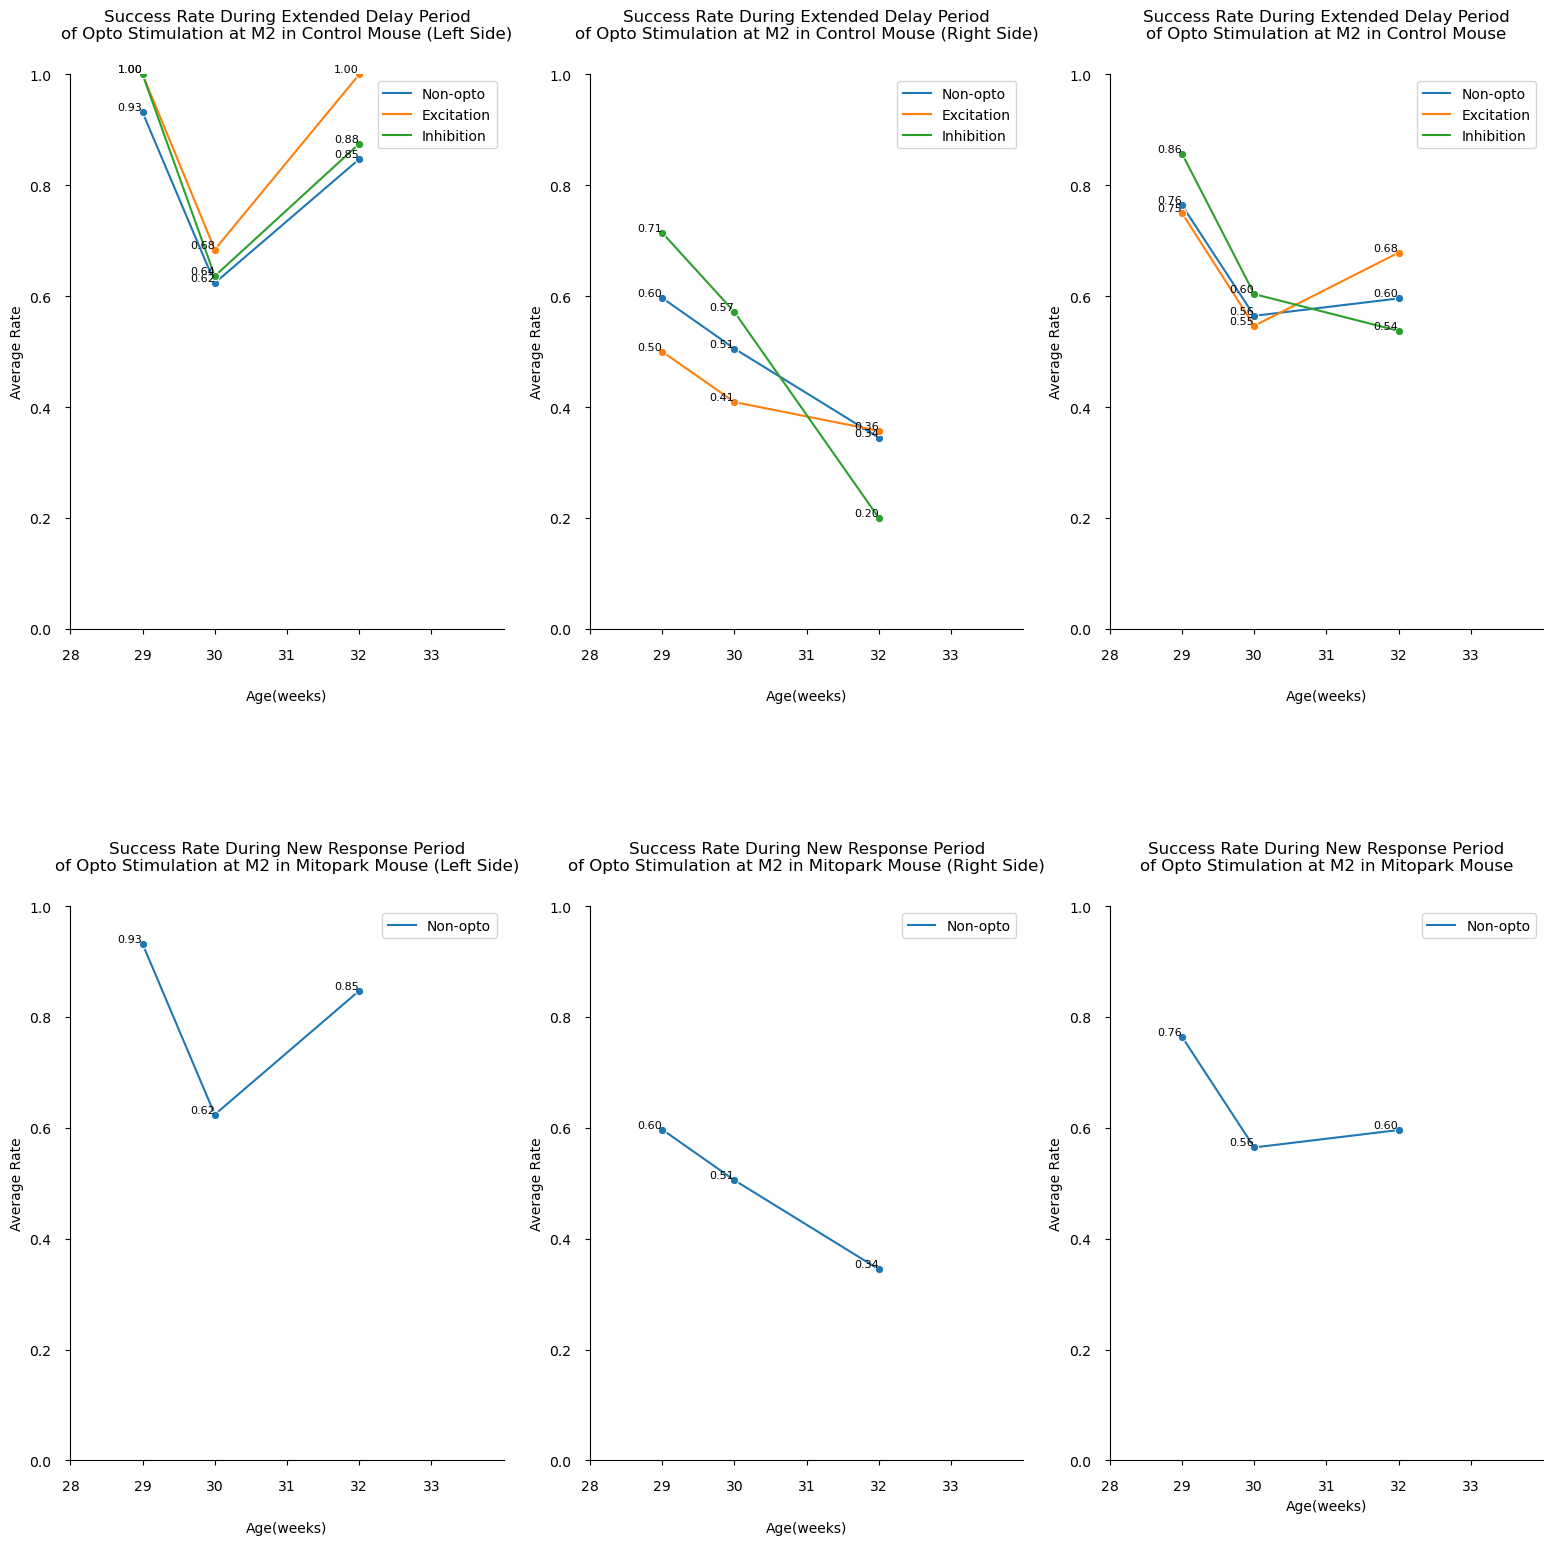

In [21]:
# Set figures to be 2x3
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(19, 18)

# Plotting the first line plot: success rate of opto during response period, by OptoEI (ax[0][0]), Left
sns.lineplot(data=success_trials_M2[
    ((success_trials_M2.IDOptoLoc == "Opto during Delay Period") & (success_trials_M2.TrialTypes == "Left Side Trials") | (success_trials_M2.IDOptoLoc == "Non-opto")) &
    (success_trials_M2.TrialTypes == "Left Side Trials")
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[0][0])

# Annotate y-values for the first subplot (0,0)
for line in ax[0][0].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[0][0].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[0][0])
ax[0][0].set_title('Success Rate During Extended Delay Period\nof Opto Stimulation at M2 in Control Mouse (Left Side)', y=1.05)
ax[0][0].set_xlabel('Age(weeks)', labelpad=20)
ax[0][0].set_xlim(28, 34)  # Modify x-axis range
ax[0][0].set_xticks(range(28, 34))  # Add ticks for each integer value from 19 to 29
ax[0][0].set_ylabel('Average Rate')
ax[0][0].set_xlim(28, 34)  # Modify x-axis range
ax[0][0].legend(loc='upper right')
ax[0][0].set_ylim(0, 1)
ax[0][0].tick_params(axis='both', which='major', pad=10)


# Plotting the second (0,1) line plot: success rate of opto during delay period, M1, by OptoEI, Right (ax[0][1])
sns.lineplot(data=success_trials_M2[
    ((success_trials_M2.IDOptoLoc == "Opto during Delay Period") & (success_trials_M2.TrialTypes == "Right Side Trials") | (success_trials_M2.IDOptoLoc == "Non-opto")) &
    (success_trials_M2.TrialTypes == "Right Side Trials")
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[0][1])

for line in ax[0][1].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[0][1].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[0][1])
ax[0][1].set_title('Success Rate During Extended Delay Period\nof Opto Stimulation at M2 in Control Mouse (Right Side)', y=1.05)
ax[0][1].set_xlabel('Age(weeks)', labelpad=20)
ax[0][1].set_xlim(28, 34)  # Modify x-axis range
ax[0][1].set_xticks(range(28, 34))  # Add ticks for each integer value from 19 to 29
ax[0][1].set_ylabel('Average Rate')
ax[0][1].set_xlim(28, 34)  # Modify x-axis range
ax[0][1].legend(loc='upper right')
ax[0][1].set_ylim(0, 1)
ax[0][1].tick_params(axis='both', which='major', pad=10)

# Plotting the third（0，2） line plot: success rate of opto during delay period, M1, by OptoEI, both L&R
sns.lineplot(data=success_trials_M2[
    ((success_trials_M2.IDOptoLoc == "Opto during Delay Period") | (success_trials_M2.IDOptoLoc == "Non-opto"))
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[0][2])

# Annotate y-values for the first subplot
for line in ax[0][2].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[0][2].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[0][2])
ax[0][2].set_title('Success Rate During Extended Delay Period\nof Opto Stimulation at M2 in Control Mouse', y=1.05)
ax[0][2].set_xlabel('Age(weeks)', labelpad=20)
ax[0][2].set_xlim(28, 34)  # Modify x-axis range
ax[0][2].set_xticks(range(28, 34))  # Add ticks for each integer value from 19 to 29
ax[0][2].set_ylabel('Average Rate')
ax[0][2].set_xlim(28, 34)  # Modify x-axis range
ax[0][2].legend(loc='upper right')
ax[0][2].set_ylim(0, 1)
ax[0][2].tick_params(axis='both', which='major', pad=10)


# Plotting the fourth (1,0) line plot: success rate of opto during response period, M1, by OptoEI, Left (ax[1][0])
sns.lineplot(data=success_trials_M2[
    ((success_trials_M2.IDOptoLoc == "Opto during Response Period") & (success_trials_M2.TrialTypes == "Left Side Trials") | (success_trials_M2.IDOptoLoc == "Non-opto")) &
    (success_trials_M2.TrialTypes == "Left Side Trials")
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[1][0])

for line in ax[1][0].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[1][0].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[1][0])
ax[1][0].set_title('Success Rate During New Response Period\nof Opto Stimulation at M2 in Mitopark Mouse (Left Side)', y=1.05)
ax[1][0].set_xlabel('Age(weeks)', labelpad=20)
ax[1][0].set_xlim(28, 34)  # Modify x-axis range
ax[1][0].set_xticks(range(28, 34))  # Add ticks for each integer value from 19 to 29
ax[1][0].set_ylabel('Average Rate')
ax[1][0].set_xlim(28, 34)  # Modify x-axis range
ax[1][0].legend(loc='upper right')
ax[1][0].set_ylim(0, 1)
ax[1][0].tick_params(axis='both', which='major', pad=10)

# Plotting the fifth line plot: success rate of opto during response period, M1, by OptoEI, Right (ax[0][1])
sns.lineplot(data=success_trials_M2[
    ((success_trials_M2.IDOptoLoc == "Opto during Response Period") & (success_trials_M2.TrialTypes == "Right Side Trials") | (success_trials_M2.IDOptoLoc == "Non-opto")) &
    (success_trials_M2.TrialTypes == "Right Side Trials")
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[1][1])

for line in ax[1][1].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[1][1].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[1][1])
ax[1][1].set_title('Success Rate During New Response Period\nof Opto Stimulation at M2 in Mitopark Mouse (Right Side)', y=1.05)
ax[1][1].set_xlabel('Age(weeks)', labelpad=20)
ax[1][1].set_xlim(28, 34)  # Modify x-axis range
ax[1][1].set_xticks(range(28, 34))  # Add ticks for each integer value from 19 to 29
ax[1][1].set_ylabel('Average Rate')
ax[1][1].set_xlim(28, 34)  # Modify x-axis range
ax[1][1].legend(loc='upper right')
ax[1][1].set_ylim(0, 1)
ax[1][1].tick_params(axis='both', which='major', pad=10)


# Plotting the sixth line plot: success rate of opto during response period, M1, by OptoEI, L&R
sns.lineplot(data=success_trials_M2[
    ((success_trials_M2.IDOptoLoc == "Opto during Response Period") | (success_trials_M2.IDOptoLoc == "Non-opto"))
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[1][2])

for line in ax[1][2].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[1][2].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[1][2])
ax[1][2].set_title('Success Rate During New Response Period\nof Opto Stimulation at M2 in Mitopark Mouse', y=1.05)
ax[1][2].set_xlabel('Age(weeks)')
ax[1][2].set_xlim(28, 34)  # Modify x-axis range
ax[1][2].set_xticks(range(28, 34))  # Add ticks for each integer value from 19 to 29
ax[1][2].set_ylabel('Average Rate')
ax[1][2].set_xlim(28, 34)  # Modify x-axis range
ax[1][2].legend(loc='upper right')
ax[1][2].set_ylim(0, 1)
ax[1][2].tick_params(axis='both', which='major', pad=10)


plt.subplots_adjust(hspace=0.5)

plt.show()

# Wrong-side Response Rate M1

In [22]:
Wrong_side_trials_M1 = all_outcomes[(all_outcomes.Outcome == "Wrong Side Reach")&(all_outcomes.Location == "M1")]

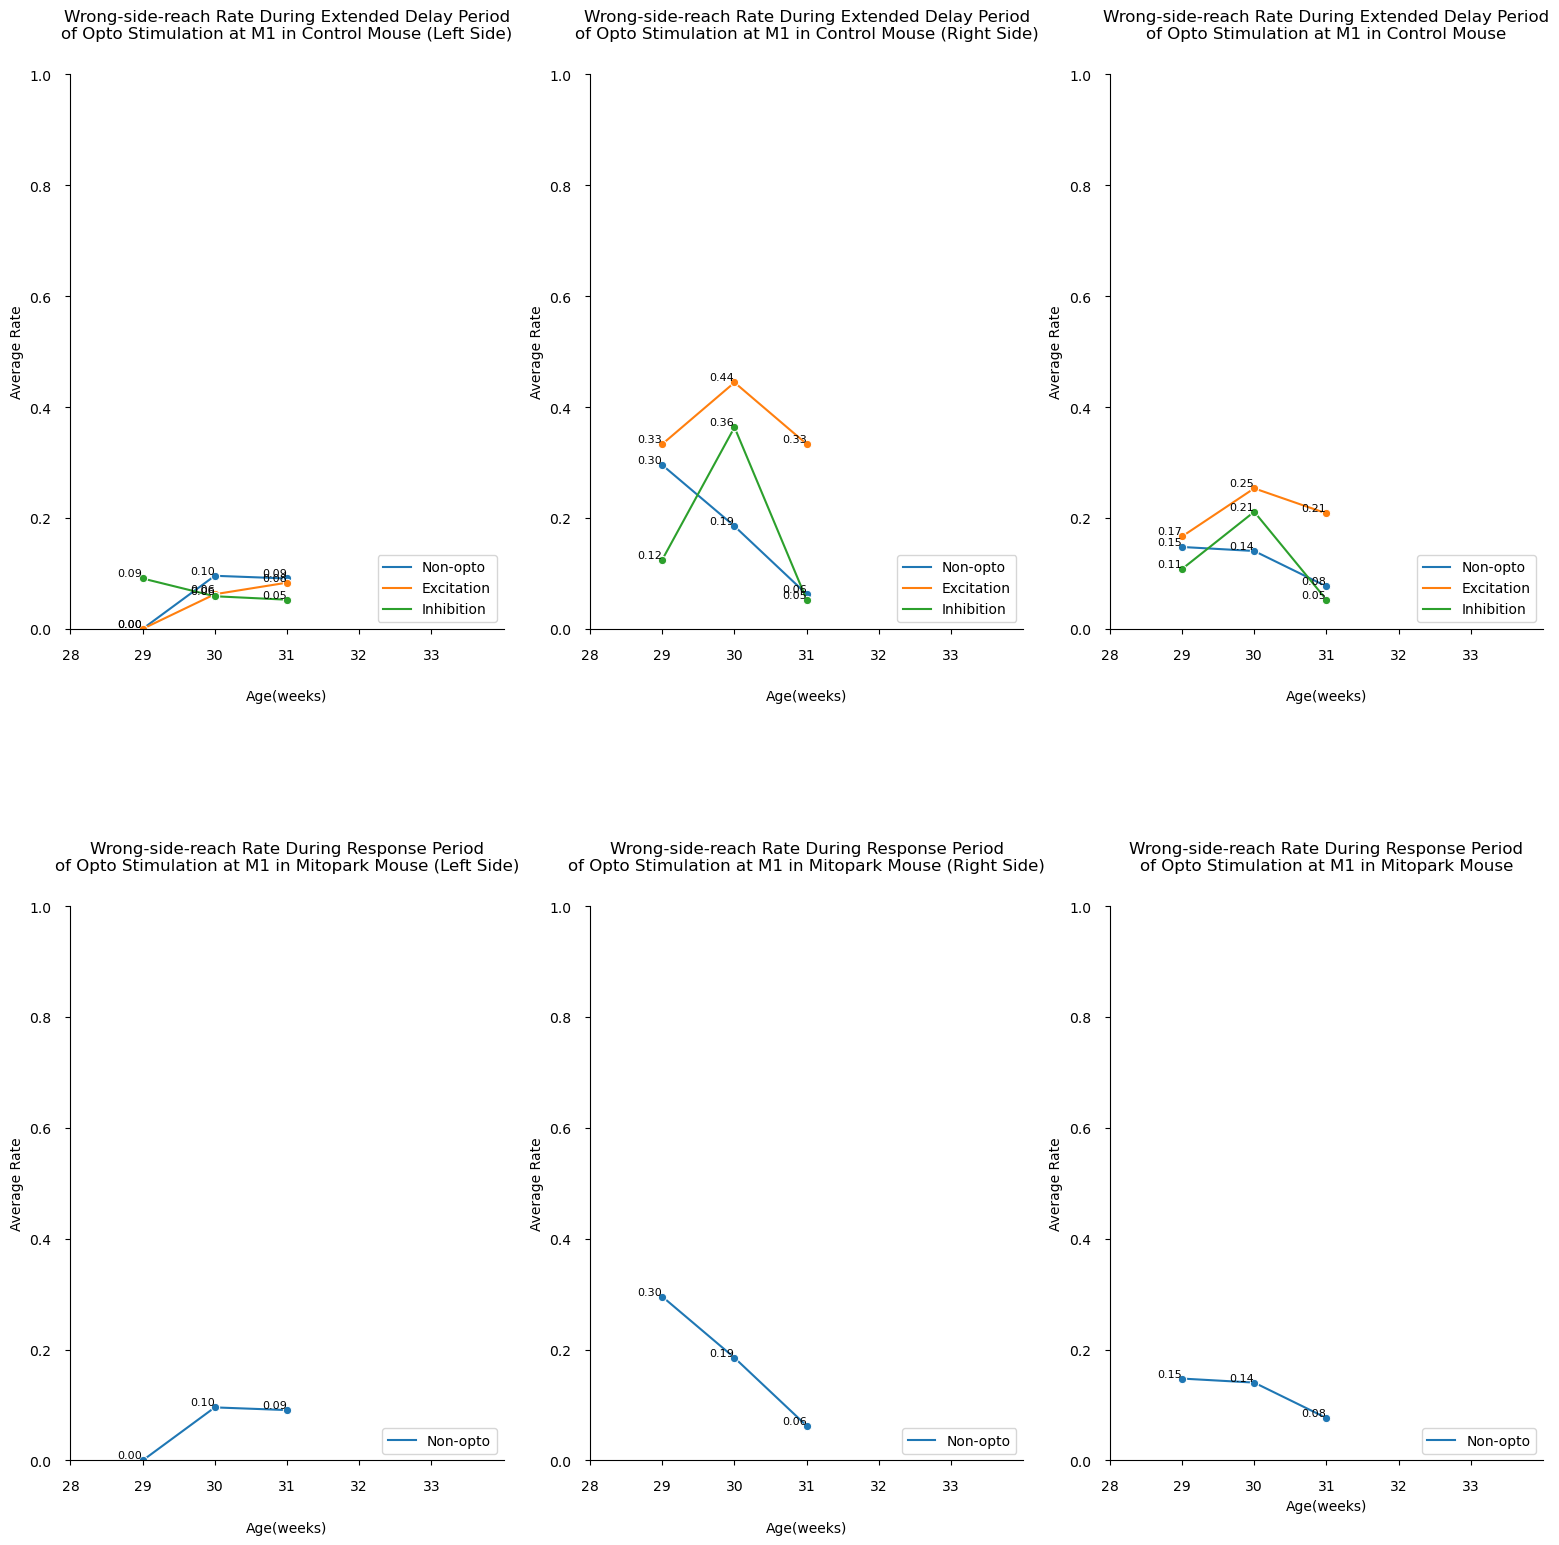

In [23]:
# Set figures to be 2x3
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(19, 18)

# Plotting the first line plot: success rate of opto during response period, by OptoEI (ax[0][0]), Left
sns.lineplot(data=Wrong_side_trials_M1[
    ((Wrong_side_trials_M1.IDOptoLoc == "Opto during Delay Period") & (Wrong_side_trials_M1.TrialTypes == "Left Side Trials") | (Wrong_side_trials_M1.IDOptoLoc == "Non-opto")) &
    (Wrong_side_trials_M1.TrialTypes == "Left Side Trials")
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[0][0])

# Annotate y-values for the first subplot (0,0)
for line in ax[0][0].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[0][0].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[0][0])
ax[0][0].set_title('Wrong-side-reach Rate During Extended Delay Period\nof Opto Stimulation at M1 in Control Mouse (Left Side)', y=1.05)
ax[0][0].set_xlabel('Age(weeks)', labelpad=20)
ax[0][0].set_xlim(28,34)  # Modify x-axis range
ax[0][0].set_xticks(range(28,34))  # Add ticks for each integer value from 19 to 29
ax[0][0].set_ylabel('Average Rate')
ax[0][0].set_xlim(28,34)  # Modify x-axis range
ax[0][0].legend(loc='lower right')
ax[0][0].set_ylim(0, 1)
ax[0][0].tick_params(axis='both', which='major', pad=10)


# Plotting the second (0,1) line plot: success rate of opto during delay period, M1, by OptoEI, Right (ax[0][1])
sns.lineplot(data=Wrong_side_trials_M1[
    ((Wrong_side_trials_M1.IDOptoLoc == "Opto during Delay Period") & (Wrong_side_trials_M1.TrialTypes == "Right Side Trials") | (Wrong_side_trials_M1.IDOptoLoc == "Non-opto")) &
    (Wrong_side_trials_M1.TrialTypes == "Right Side Trials")
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[0][1])

for line in ax[0][1].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[0][1].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[0][1])
ax[0][1].set_title('Wrong-side-reach Rate During Extended Delay Period\nof Opto Stimulation at M1 in Control Mouse (Right Side)', y=1.05)
ax[0][1].set_xlabel('Age(weeks)', labelpad=20)
ax[0][1].set_xlim(28,34)  # Modify x-axis range
ax[0][1].set_xticks(range(28,34))  # Add ticks for each integer value from 19 to 29
ax[0][1].set_ylabel('Average Rate')
ax[0][1].set_xlim(28,34)  # Modify x-axis range
ax[0][1].legend(loc='lower right')
ax[0][1].set_ylim(0, 1)
ax[0][1].tick_params(axis='both', which='major', pad=10)

# Plotting the third（0，2） line plot: success rate of opto during delay period, M1, by OptoEI, both L&R
sns.lineplot(data=Wrong_side_trials_M1[
    ((Wrong_side_trials_M1.IDOptoLoc == "Opto during Delay Period") | (Wrong_side_trials_M1.IDOptoLoc == "Non-opto"))
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[0][2])

# Annotate y-values for the first subplot
for line in ax[0][2].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[0][2].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[0][2])
ax[0][2].set_title('Wrong-side-reach Rate During Extended Delay Period\nof Opto Stimulation at M1 in Control Mouse', y=1.05)
ax[0][2].set_xlabel('Age(weeks)', labelpad=20)
ax[0][2].set_xlim(28,34)  # Modify x-axis range
ax[0][2].set_xticks(range(28,34))  # Add ticks for each integer value from 19 to 29
ax[0][2].set_ylabel('Average Rate')
ax[0][2].set_xlim(28,34)  # Modify x-axis range
ax[0][2].legend(loc='lower right')
ax[0][2].set_ylim(0, 1)
ax[0][2].tick_params(axis='both', which='major', pad=10)


# Plotting the fourth (1,0) line plot: success rate of opto during response period, M1, by OptoEI, Left (ax[1][0])
sns.lineplot(data=Wrong_side_trials_M1[
    ((Wrong_side_trials_M1.IDOptoLoc == "Opto during Response Period") & (Wrong_side_trials_M1.TrialTypes == "Left Side Trials") | (Wrong_side_trials_M1.IDOptoLoc == "Non-opto")) &
    (Wrong_side_trials_M1.TrialTypes == "Left Side Trials")
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[1][0])

for line in ax[1][0].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[1][0].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[1][0])
ax[1][0].set_title('Wrong-side-reach Rate During Response Period\nof Opto Stimulation at M1 in Mitopark Mouse (Left Side)', y=1.05)
ax[1][0].set_xlabel('Age(weeks)', labelpad=20)
ax[1][0].set_xlim(28,34)  # Modify x-axis range
ax[1][0].set_xticks(range(28,34))  # Add ticks for each integer value from 19 to 29
ax[1][0].set_ylabel('Average Rate')
ax[1][0].set_xlim(28,34)  # Modify x-axis range
ax[1][0].legend(loc='lower right')
ax[1][0].set_ylim(0, 1)
ax[1][0].tick_params(axis='both', which='major', pad=10)

# Plotting the fifth line plot: success rate of opto during response period, M1, by OptoEI, Right (ax[0][1])
sns.lineplot(data=Wrong_side_trials_M1[
    ((Wrong_side_trials_M1.IDOptoLoc == "Opto during Response Period") & (Wrong_side_trials_M1.TrialTypes == "Right Side Trials") | (Wrong_side_trials_M1.IDOptoLoc == "Non-opto")) &
    (Wrong_side_trials_M1.TrialTypes == "Right Side Trials")
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[1][1])

for line in ax[1][1].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[1][1].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[1][1])
ax[1][1].set_title('Wrong-side-reach Rate During Response Period\nof Opto Stimulation at M1 in Mitopark Mouse (Right Side)', y=1.05)
ax[1][1].set_xlabel('Age(weeks)', labelpad=20)
ax[1][1].set_xlim(28,34)  # Modify x-axis range
ax[1][1].set_xticks(range(28,34))  # Add ticks for each integer value from 19 to 29
ax[1][1].set_ylabel('Average Rate')
ax[1][1].set_xlim(28,34)  # Modify x-axis range
ax[1][1].legend(loc='lower right')
ax[1][1].set_ylim(0, 1)
ax[1][1].tick_params(axis='both', which='major', pad=10)


# Plotting the sixth line plot: success rate of opto during response period, M1, by OptoEI, L&R
sns.lineplot(data=Wrong_side_trials_M1[
    ((Wrong_side_trials_M1.IDOptoLoc == "Opto during Response Period") | (Wrong_side_trials_M1.IDOptoLoc == "Non-opto"))
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[1][2])

for line in ax[1][2].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[1][2].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[1][2])
ax[1][2].set_title('Wrong-side-reach Rate During Response Period\nof Opto Stimulation at M1 in Mitopark Mouse', y=1.05)
ax[1][2].set_xlabel('Age(weeks)')
ax[1][2].set_xlim(28,34)  # Modify x-axis range
ax[1][2].set_xticks(range(28,34))  # Add ticks for each integer value from 19 to 29
ax[1][2].set_ylabel('Average Rate')
ax[1][2].set_xlim(28,34)  # Modify x-axis range
ax[1][2].legend(loc='lower right')
ax[1][2].set_ylim(0, 1)
ax[1][2].tick_params(axis='both', which='major', pad=10)


plt.subplots_adjust(hspace=0.5)

plt.show()


# Wrong-side Response Rate M2

In [24]:
# drop these values to select opto trials
df.drop(df[
    (df["OptoState"] != "Non-opto trials") & \
    (df["IDOptoLoc"].isin(["Non-opto", "Opto in Consumption Period"]) | df["OptoEI"].isin(["Non-opto"]))].index,
        inplace=True)

In [25]:
Wrong_side_trials_M2 = all_outcomes[(all_outcomes.Outcome == "Wrong Side Reach")&(all_outcomes.Location == "M2")]

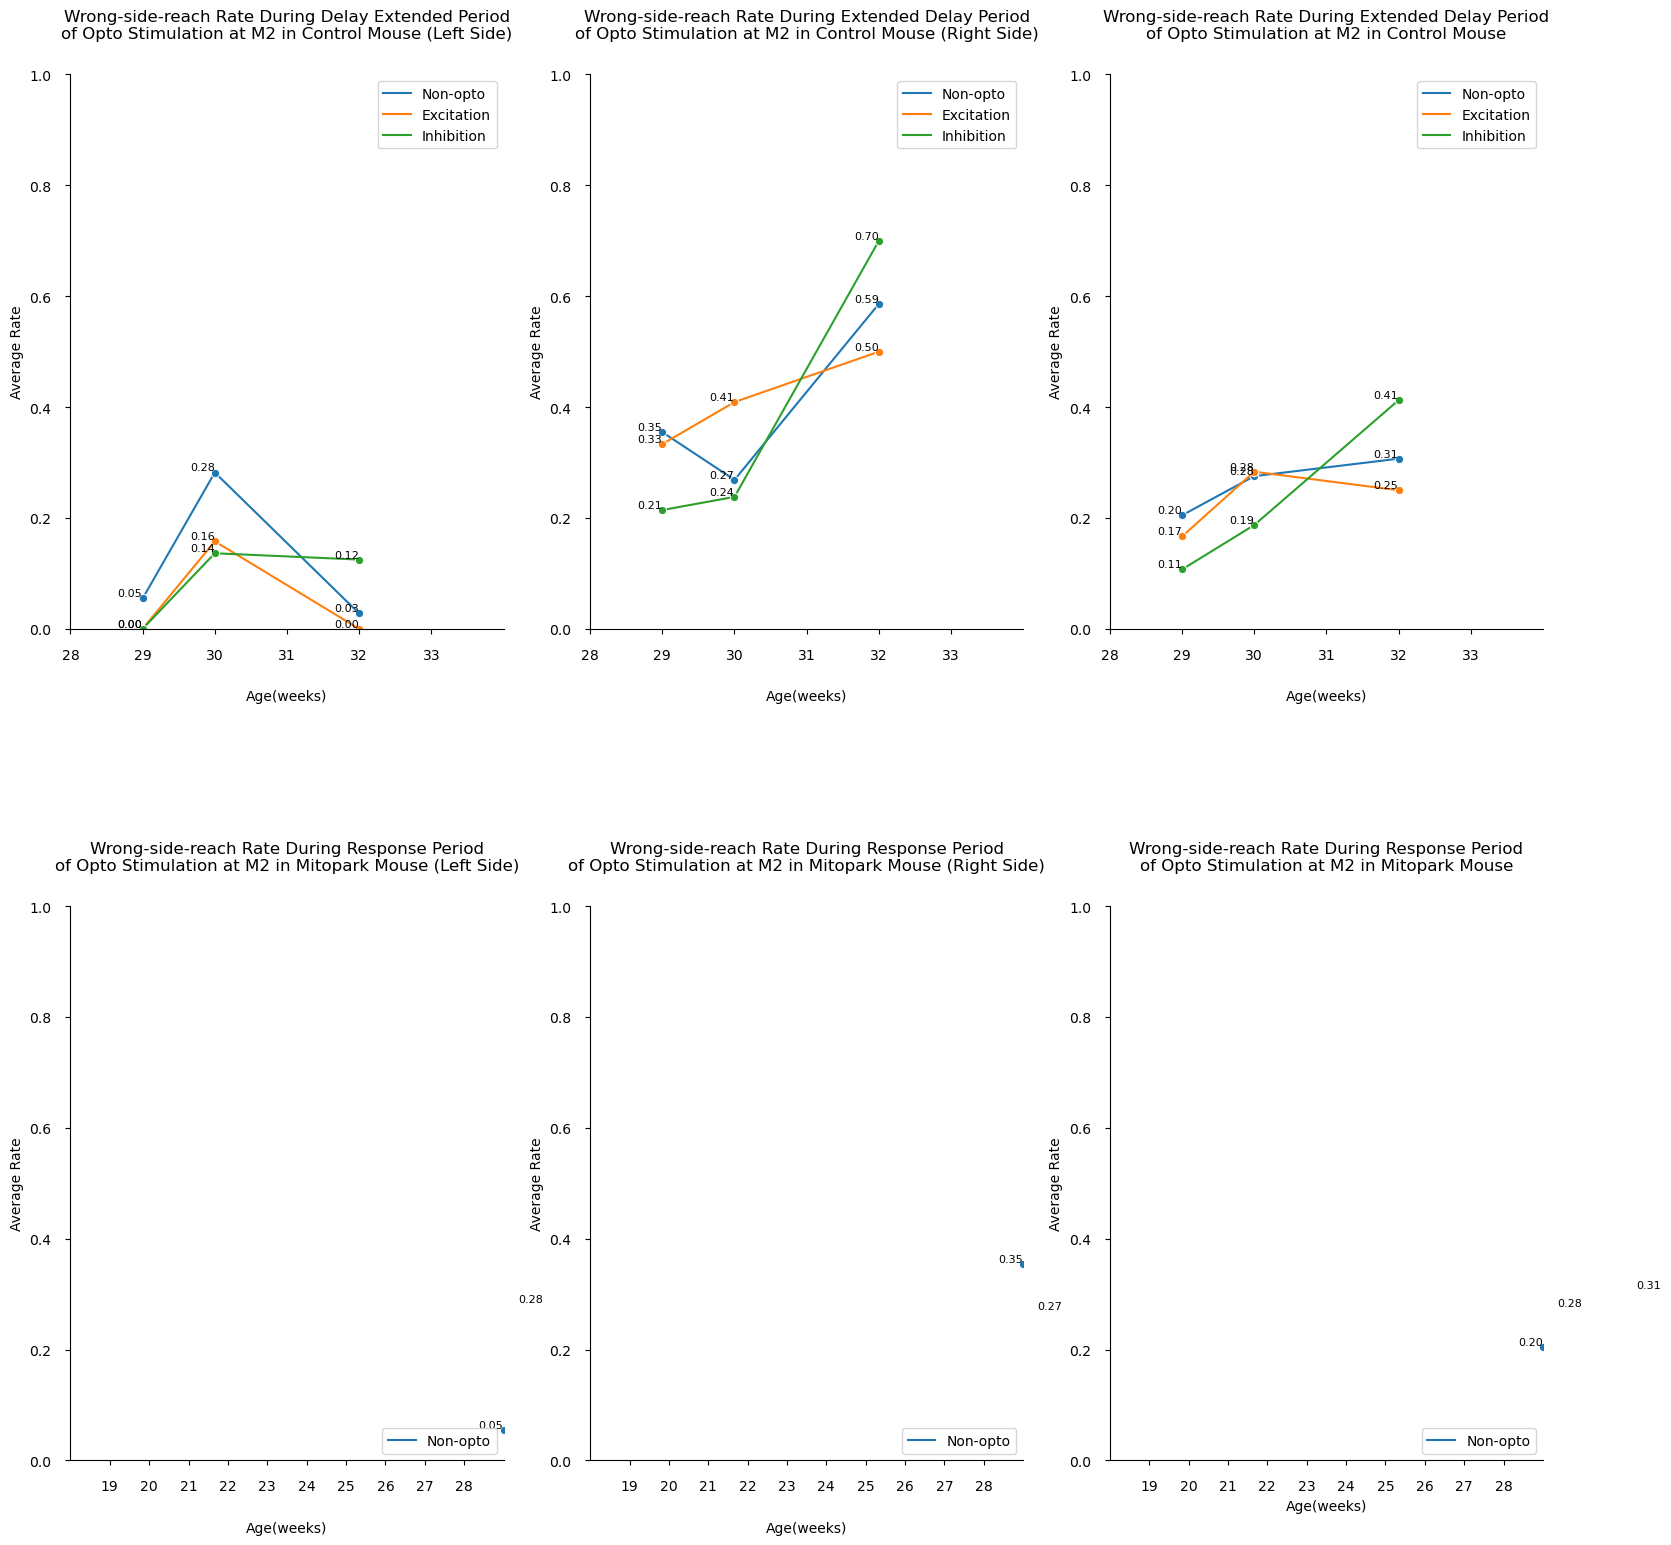

In [26]:
# Set figures to be 2x3
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(19, 18)

# Plotting the first line plot: success rate of opto during response period, by OptoEI (ax[0][0]), Left
sns.lineplot(data=Wrong_side_trials_M2[
    ((Wrong_side_trials_M2.IDOptoLoc == "Opto during Delay Period") & (Wrong_side_trials_M2.TrialTypes == "Left Side Trials") | (Wrong_side_trials_M2.IDOptoLoc == "Non-opto")) &
    (Wrong_side_trials_M2.TrialTypes == "Left Side Trials")
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[0][0])

# Annotate y-values for the first subplot (0,0)
for line in ax[0][0].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[0][0].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[0][0])
ax[0][0].set_title('Wrong-side-reach Rate During Delay Extended Period\nof Opto Stimulation at M2 in Control Mouse (Left Side)', y=1.05)
ax[0][0].set_xlabel('Age(weeks)', labelpad=20)
ax[0][0].set_xlim(28, 34)  # Modify x-axis range
ax[0][0].set_xticks(range(28, 34))  # Add ticks for each integer value from 19 to 29
ax[0][0].set_ylabel('Average Rate')
ax[0][0].set_xlim(28, 34)  # Modify x-axis range
ax[0][0].legend(loc='upper right')
ax[0][0].set_ylim(0, 1)
ax[0][0].tick_params(axis='both', which='major', pad=10)


# Plotting the second (0,1) line plot: success rate of opto during delay period, M2, by OptoEI, Right (ax[0][1])
sns.lineplot(data=Wrong_side_trials_M2[
    ((Wrong_side_trials_M2.IDOptoLoc == "Opto during Delay Period") & (Wrong_side_trials_M2.TrialTypes == "Right Side Trials") | (Wrong_side_trials_M2.IDOptoLoc == "Non-opto")) &
    (Wrong_side_trials_M2.TrialTypes == "Right Side Trials")
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[0][1])

for line in ax[0][1].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[0][1].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[0][1])
ax[0][1].set_title('Wrong-side-reach Rate During Extended Delay Period\nof Opto Stimulation at M2 in Control Mouse (Right Side)', y=1.05)
ax[0][1].set_xlabel('Age(weeks)', labelpad=20)
ax[0][1].set_xlim(28, 34)  # Modify x-axis range
ax[0][1].set_xticks(range(28, 34))  # Add ticks for each integer value from 19 to 29
ax[0][1].set_ylabel('Average Rate')
ax[0][1].set_xlim(28, 34)  # Modify x-axis range
ax[0][1].legend(loc='upper right')
ax[0][1].set_ylim(0, 1)
ax[0][1].tick_params(axis='both', which='major', pad=10)

# Plotting the third（0，2） line plot: success rate of opto during delay period, M2, by OptoEI, both L&R
sns.lineplot(data=Wrong_side_trials_M2[
    ((Wrong_side_trials_M2.IDOptoLoc == "Opto during Delay Period") | (Wrong_side_trials_M2.IDOptoLoc == "Non-opto"))
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[0][2])

# Annotate y-values for the first subplot
for line in ax[0][2].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[0][2].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[0][2])
ax[0][2].set_title('Wrong-side-reach Rate During Extended Delay Period\nof Opto Stimulation at M2 in Control Mouse', y=1.05)
ax[0][2].set_xlabel('Age(weeks)', labelpad=20)
ax[0][2].set_xlim(28, 34)  # Modify x-axis range
ax[0][2].set_xticks(range(28, 34))  # Add ticks for each integer value from 19 to 29
ax[0][2].set_ylabel('Average Rate')
ax[0][2].set_xlim(28, 34)  # Modify x-axis range
ax[0][2].legend(loc='upper right')
ax[0][2].set_ylim(0, 1)
ax[0][2].tick_params(axis='both', which='major', pad=10)


# Plotting the fourth (1,0) line plot: success rate of opto during response period, M2, by OptoEI, Left (ax[1][0])
sns.lineplot(data=Wrong_side_trials_M2[
    ((Wrong_side_trials_M2.IDOptoLoc == "Opto during Response Period") & (Wrong_side_trials_M2.TrialTypes == "Left Side Trials") | (Wrong_side_trials_M2.IDOptoLoc == "Non-opto")) &
    (Wrong_side_trials_M2.TrialTypes == "Left Side Trials")
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[1][0])

for line in ax[1][0].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[1][0].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[1][0])
ax[1][0].set_title('Wrong-side-reach Rate During Response Period\nof Opto Stimulation at M2 in Mitopark Mouse (Left Side)', y=1.05)
ax[1][0].set_xlabel('Age(weeks)', labelpad=20)
ax[1][0].set_xlim(18, 29)  # Modify x-axis range
ax[1][0].set_xticks(range(19, 29))  # Add ticks for each integer value from 19 to 29
ax[1][0].set_ylabel('Average Rate')
ax[1][0].set_xlim(18, 29)  # Modify x-axis range
ax[1][0].legend(loc='lower right')
ax[1][0].set_ylim(0, 1)
ax[1][0].tick_params(axis='both', which='major', pad=10)

# Plotting the fifth line plot: success rate of opto during response period, M2, by OptoEI, Right (ax[0][1])
sns.lineplot(data=Wrong_side_trials_M2[
    ((Wrong_side_trials_M2.IDOptoLoc == "Opto during Response Period") & (Wrong_side_trials_M2.TrialTypes == "Right Side Trials") | (Wrong_side_trials_M2.IDOptoLoc == "Non-opto")) &
    (Wrong_side_trials_M2.TrialTypes == "Right Side Trials")
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[1][1])

for line in ax[1][1].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[1][1].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[1][1])
ax[1][1].set_title('Wrong-side-reach Rate During Response Period\nof Opto Stimulation at M2 in Mitopark Mouse (Right Side)', y=1.05)
ax[1][1].set_xlabel('Age(weeks)', labelpad=20)
ax[1][1].set_xlim(18, 29)  # Modify x-axis range
ax[1][1].set_xticks(range(19, 29))  # Add ticks for each integer value from 19 to 29
ax[1][1].set_ylabel('Average Rate')
ax[1][1].set_xlim(18, 29)  # Modify x-axis range
ax[1][1].legend(loc='lower right')
ax[1][1].set_ylim(0, 1)
ax[1][1].tick_params(axis='both', which='major', pad=10)


# Plotting the sixth line plot: success rate of opto during response period, M2, by OptoEI, L&R
sns.lineplot(data=Wrong_side_trials_M2[
    ((Wrong_side_trials_M2.IDOptoLoc == "Opto during Response Period") | (Wrong_side_trials_M2.IDOptoLoc == "Non-opto"))
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[1][2])

for line in ax[1][2].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[1][2].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[1][2])
ax[1][2].set_title('Wrong-side-reach Rate During Response Period\nof Opto Stimulation at M2 in Mitopark Mouse', y=1.05)
ax[1][2].set_xlabel('Age(weeks)')
ax[1][2].set_xlim(18, 29)  # Modify x-axis range
ax[1][2].set_xticks(range(19, 29))  # Add ticks for each integer value from 19 to 29
ax[1][2].set_ylabel('Average Rate')
ax[1][2].set_xlim(18, 29)  # Modify x-axis range
ax[1][2].legend(loc='lower right')
ax[1][2].set_ylim(0, 1)
ax[1][2].tick_params(axis='both', which='major', pad=10)


plt.subplots_adjust(hspace=0.5)

plt.show()


# No-response Rate M1

In [27]:
non_response_trials_M1 = all_outcomes[(all_outcomes.Outcome == "No Response")&(all_outcomes.Location == "M1")]

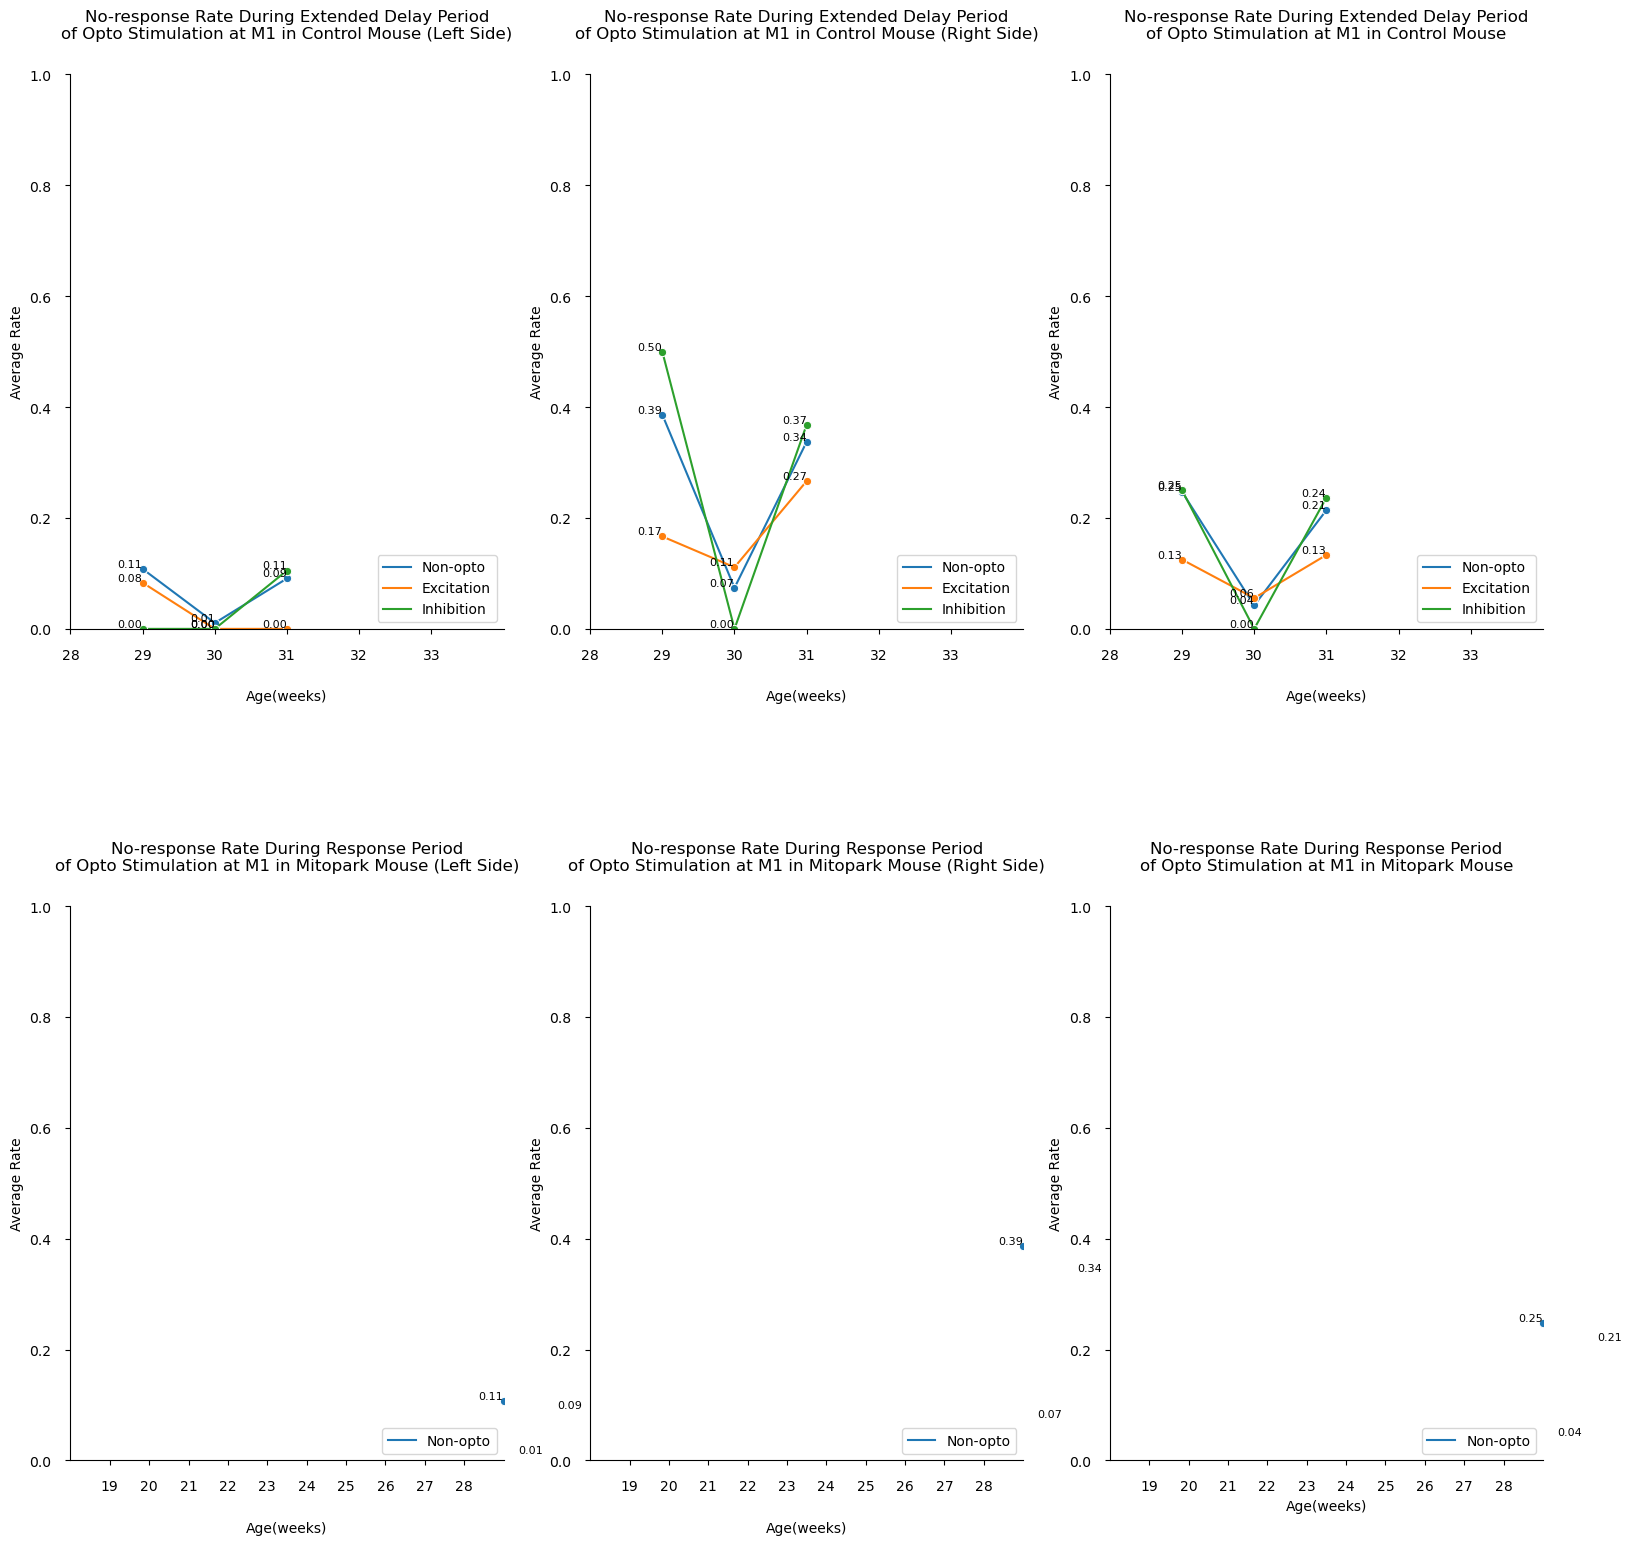

In [28]:
# Set figures to be 2x3
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(19, 18)

# Plotting the first line plot: success rate of opto during response period, by OptoEI (ax[0][0]), Left
sns.lineplot(data=non_response_trials_M1[
    ((non_response_trials_M1.IDOptoLoc == "Opto during Delay Period") & (non_response_trials_M1.TrialTypes == "Left Side Trials") | (non_response_trials_M1.IDOptoLoc == "Non-opto")) &
    (non_response_trials_M1.TrialTypes == "Left Side Trials")
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[0][0])

# Annotate y-values for the first subplot (0,0)
for line in ax[0][0].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[0][0].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[0][0])
ax[0][0].set_title('No-response Rate During Extended Delay Period\nof Opto Stimulation at M1 in Control Mouse (Left Side)', y=1.05)
ax[0][0].set_xlabel('Age(weeks)', labelpad=20)
ax[0][0].set_xlim(28, 34)  # Modify x-axis range
ax[0][0].set_xticks(range(28, 34))  # Add ticks for each integer value from 19 to 29
ax[0][0].set_ylabel('Average Rate')
ax[0][0].set_xlim(28, 34)  # Modify x-axis range
ax[0][0].legend(loc='lower right')
ax[0][0].set_ylim(0, 1)
ax[0][0].tick_params(axis='both', which='major', pad=10)

# Plotting the second (0,1) line plot: success rate of opto during delay period, M1, by OptoEI, Right (ax[0][1])
sns.lineplot(data=non_response_trials_M1[
    ((non_response_trials_M1.IDOptoLoc == "Opto during Delay Period") & (non_response_trials_M1.TrialTypes == "Right Side Trials") | (non_response_trials_M1.IDOptoLoc == "Non-opto")) &
    (non_response_trials_M1.TrialTypes == "Right Side Trials")
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[0][1])

for line in ax[0][1].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[0][1].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[0][1])
ax[0][1].set_title('No-response Rate During Extended Delay Period\nof Opto Stimulation at M1 in Control Mouse (Right Side)', y=1.05)
ax[0][1].set_xlabel('Age(weeks)', labelpad=20)
ax[0][1].set_xlim(28, 34)  # Modify x-axis range
ax[0][1].set_xticks(range(28, 34))  # Add ticks for each integer value from 19 to 29
ax[0][1].set_ylabel('Average Rate')
ax[0][1].set_xlim(28, 34)  # Modify x-axis range
ax[0][1].legend(loc='lower right')
ax[0][1].set_ylim(0, 1)
ax[0][1].tick_params(axis='both', which='major', pad=10)

# Plotting the third（0，2） line plot: success rate of opto during delay period, M1, by OptoEI, both L&R
sns.lineplot(data=non_response_trials_M1[
    ((non_response_trials_M1.IDOptoLoc == "Opto during Delay Period") | (non_response_trials_M1.IDOptoLoc == "Non-opto"))
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[0][2])

# Annotate y-values for the first subplot
for line in ax[0][2].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[0][2].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[0][2])
ax[0][2].set_title('No-response Rate During Extended Delay Period\nof Opto Stimulation at M1 in Control Mouse', y=1.05)
ax[0][2].set_xlabel('Age(weeks)', labelpad=20)
ax[0][2].set_xlim(28, 34)  # Modify x-axis range
ax[0][2].set_xticks(range(28, 34))  # Add ticks for each integer value from 19 to 29
ax[0][2].set_ylabel('Average Rate')
ax[0][2].set_xlim(28, 34)  # Modify x-axis range
ax[0][2].legend(loc='lower right')
ax[0][2].set_ylim(0, 1)
ax[0][2].tick_params(axis='both', which='major', pad=10)


# Plotting the fourth (1,0) line plot: success rate of opto during response period, M1, by OptoEI, Left (ax[1][0])
sns.lineplot(data=non_response_trials_M1[
    ((non_response_trials_M1.IDOptoLoc == "Opto during Response Period") & (non_response_trials_M1.TrialTypes == "Left Side Trials") | (non_response_trials_M1.IDOptoLoc == "Non-opto")) &
    (non_response_trials_M1.TrialTypes == "Left Side Trials")
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[1][0])

for line in ax[1][0].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[1][0].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[1][0])
ax[1][0].set_title('No-response Rate During Response Period\nof Opto Stimulation at M1 in Mitopark Mouse (Left Side)', y=1.05)
ax[1][0].set_xlabel('Age(weeks)', labelpad=20)
ax[1][0].set_xlim(18, 29)  # Modify x-axis range
ax[1][0].set_xticks(range(19, 29))  # Add ticks for each integer value from 19 to 29
ax[1][0].set_ylabel('Average Rate')
ax[1][0].set_xlim(18, 29)  # Modify x-axis range
ax[1][0].legend(loc='lower right')
ax[1][0].set_ylim(0, 1)
ax[1][0].tick_params(axis='both', which='major', pad=10)

# Plotting the fifth line plot: success rate of opto during response period, M1, by OptoEI, Right (ax[0][1])
sns.lineplot(data=non_response_trials_M1[
    ((non_response_trials_M1.IDOptoLoc == "Opto during Response Period") & (non_response_trials_M1.TrialTypes == "Right Side Trials") | (non_response_trials_M1.IDOptoLoc == "Non-opto")) &
    (non_response_trials_M1.TrialTypes == "Right Side Trials")
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[1][1])

for line in ax[1][1].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[1][1].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[1][1])
ax[1][1].set_title('No-response Rate During Response Period\nof Opto Stimulation at M1 in Mitopark Mouse (Right Side)', y=1.05)
ax[1][1].set_xlabel('Age(weeks)', labelpad=20)
ax[1][1].set_xlim(18, 29)  # Modify x-axis range
ax[1][1].set_xticks(range(19, 29))  # Add ticks for each integer value from 19 to 29
ax[1][1].set_ylabel('Average Rate')
ax[1][1].set_xlim(18, 29)  # Modify x-axis range
ax[1][1].legend(loc='lower right')
ax[1][1].set_ylim(0, 1)
ax[1][1].tick_params(axis='both', which='major', pad=10)


# Plotting the sixth line plot: success rate of opto during response period, M1, by OptoEI, L&R
sns.lineplot(data=non_response_trials_M1[
    ((non_response_trials_M1.IDOptoLoc == "Opto during Response Period") | (non_response_trials_M1.IDOptoLoc == "Non-opto"))
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[1][2])

for line in ax[1][2].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[1][2].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[1][2])
ax[1][2].set_title('No-response Rate During Response Period\nof Opto Stimulation at M1 in Mitopark Mouse', y=1.05)
ax[1][2].set_xlabel('Age(weeks)')
ax[1][2].set_xlim(18, 29)  # Modify x-axis range
ax[1][2].set_xticks(range(19, 29))  # Add ticks for each integer value from 19 to 29
ax[1][2].set_ylabel('Average Rate')
ax[1][2].set_xlim(18, 29)  # Modify x-axis range
ax[1][2].legend(loc='lower right')
ax[1][2].set_ylim(0, 1)
ax[1][2].tick_params(axis='both', which='major', pad=10)


plt.subplots_adjust(hspace=0.5)

plt.show()


# No-response Rate M2

In [29]:
non_response_trials_M2 = all_outcomes[(all_outcomes.Outcome == "No Response")&(all_outcomes.Location == "M2")]

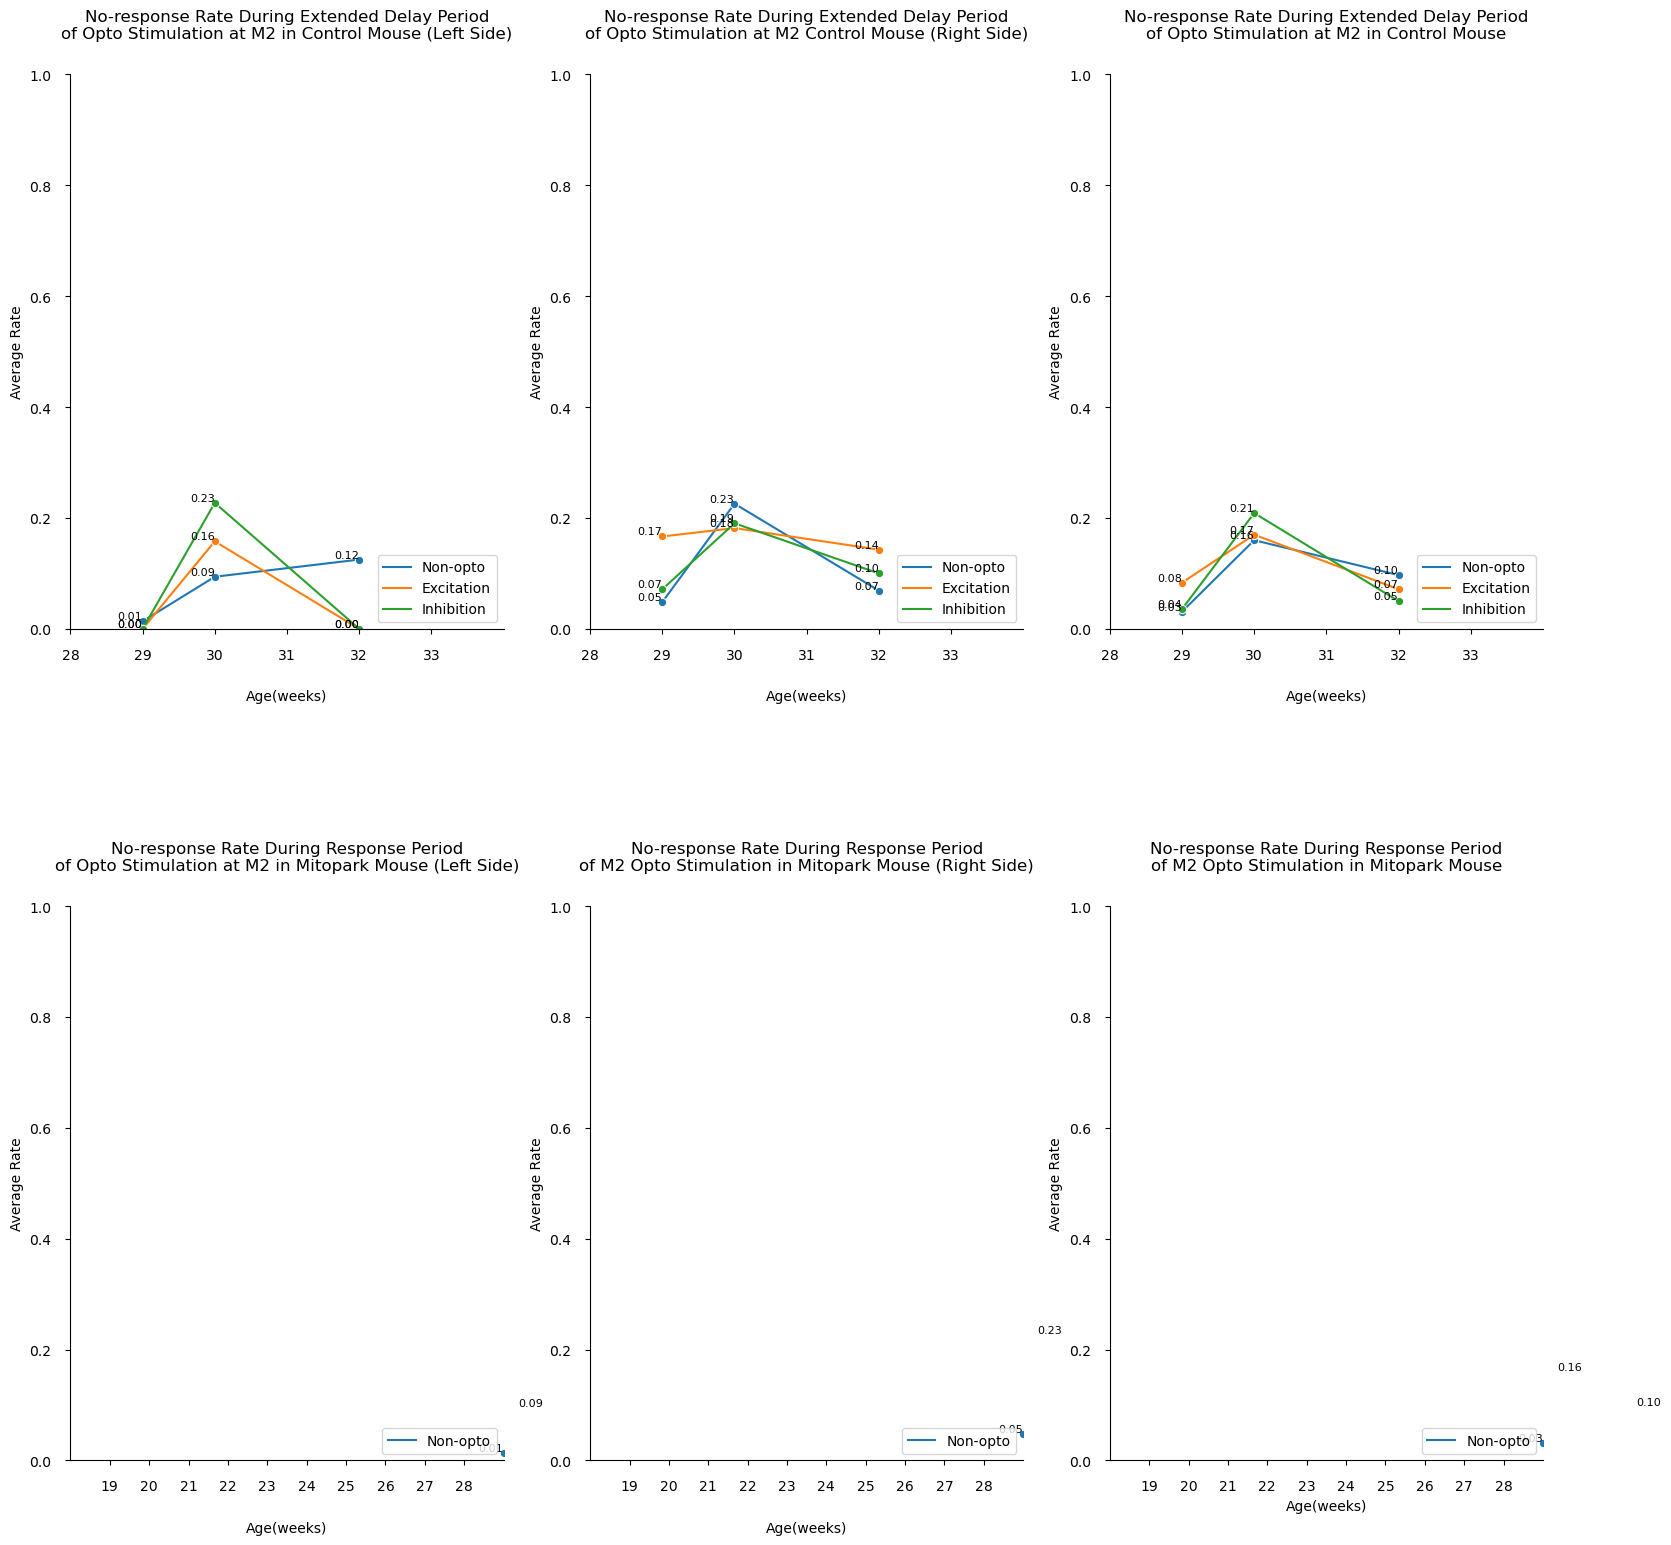

In [30]:
# Set figures to be 2x3
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(19, 18)

# Plotting the first line plot: success rate of opto during response period, by OptoEI (ax[0][0]), Left
sns.lineplot(data=non_response_trials_M2[
    ((non_response_trials_M2.IDOptoLoc == "Opto during Delay Period") & (non_response_trials_M2.TrialTypes == "Left Side Trials") | (non_response_trials_M2.IDOptoLoc == "Non-opto")) &
    (non_response_trials_M2.TrialTypes == "Left Side Trials")
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[0][0])

# Annotate y-values for the first subplot (0,0)
for line in ax[0][0].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[0][0].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[0][0])
ax[0][0].set_title('No-response Rate During Extended Delay Period\nof Opto Stimulation at M2 in Control Mouse (Left Side)', y=1.05)
ax[0][0].set_xlabel('Age(weeks)', labelpad=20)
ax[0][0].set_xlim(28, 34)  # Modify x-axis range
ax[0][0].set_xticks(range(28, 34))  # Add ticks for each integer value from 19 to 29
ax[0][0].set_ylabel('Average Rate')
ax[0][0].set_xlim(28, 34)  # Modify x-axis range
ax[0][0].legend(loc='lower right')
ax[0][0].set_ylim(0, 1)
ax[0][0].tick_params(axis='both', which='major', pad=10)

# Plotting the second (0,1) line plot: success rate of opto during delay period, M1, by OptoEI, Right (ax[0][1])
sns.lineplot(data=non_response_trials_M2[
    ((non_response_trials_M2.IDOptoLoc == "Opto during Delay Period") & (non_response_trials_M2.TrialTypes == "Right Side Trials") | (non_response_trials_M2.IDOptoLoc == "Non-opto")) &
    (non_response_trials_M2.TrialTypes == "Right Side Trials")
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[0][1])

for line in ax[0][1].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[0][1].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[0][1])
ax[0][1].set_title('No-response Rate During Extended Delay Period\nof Opto Stimulation at M2 Control Mouse (Right Side)', y=1.05)
ax[0][1].set_xlabel('Age(weeks)', labelpad=20)
ax[0][1].set_xlim(28, 34)  # Modify x-axis range
ax[0][1].set_xticks(range(28, 34))  # Add ticks for each integer value from 19 to 29
ax[0][1].set_ylabel('Average Rate')
ax[0][1].set_xlim(28, 34)  # Modify x-axis range
ax[0][1].legend(loc='lower right')
ax[0][1].set_ylim(0, 1)
ax[0][1].tick_params(axis='both', which='major', pad=10)

# Plotting the third（0，2） line plot: success rate of opto during delay period, M1, by OptoEI, both L&R
sns.lineplot(data=non_response_trials_M2[
    ((non_response_trials_M2.IDOptoLoc == "Opto during Delay Period") | (non_response_trials_M2.IDOptoLoc == "Non-opto"))
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[0][2])

# Annotate y-values for the first subplot
for line in ax[0][2].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[0][2].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[0][2])
ax[0][2].set_title('No-response Rate During Extended Delay Period\nof Opto Stimulation at M2 in Control Mouse', y=1.05)
ax[0][2].set_xlabel('Age(weeks)', labelpad=20)
ax[0][2].set_xlim(28, 34)  # Modify x-axis range
ax[0][2].set_xticks(range(28, 34))  # Add ticks for each integer value from 19 to 29
ax[0][2].set_ylabel('Average Rate')
ax[0][2].set_xlim(28, 34)  # Modify x-axis range
ax[0][2].legend(loc='lower right')
ax[0][2].set_ylim(0, 1)
ax[0][2].tick_params(axis='both', which='major', pad=10)


# Plotting the fourth (1,0) line plot: success rate of opto during response period, M1, by OptoEI, Left (ax[1][0])
sns.lineplot(data=non_response_trials_M2[
    ((non_response_trials_M2.IDOptoLoc == "Opto during Response Period") & (non_response_trials_M2.TrialTypes == "Left Side Trials") | (non_response_trials_M2.IDOptoLoc == "Non-opto")) &
    (non_response_trials_M2.TrialTypes == "Left Side Trials")
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[1][0])

for line in ax[1][0].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[1][0].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[1][0])
ax[1][0].set_title('No-response Rate During Response Period\nof Opto Stimulation at M2 in Mitopark Mouse (Left Side)', y=1.05)
ax[1][0].set_xlabel('Age(weeks)', labelpad=20)
ax[1][0].set_xlim(18, 29)  # Modify x-axis range
ax[1][0].set_xticks(range(19, 29))  # Add ticks for each integer value from 19 to 29
ax[1][0].set_ylabel('Average Rate')
ax[1][0].set_xlim(18, 29)  # Modify x-axis range
ax[1][0].legend(loc='lower right')
ax[1][0].set_ylim(0, 1)
ax[1][0].tick_params(axis='both', which='major', pad=10)

# Plotting the fifth line plot: success rate of opto during response period, M1, by OptoEI, Right (ax[0][1])
sns.lineplot(data=non_response_trials_M2[
    ((non_response_trials_M2.IDOptoLoc == "Opto during Response Period") & (non_response_trials_M2.TrialTypes == "Right Side Trials") | (non_response_trials_M2.IDOptoLoc == "Non-opto")) &
    (non_response_trials_M2.TrialTypes == "Right Side Trials")
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[1][1])

for line in ax[1][1].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[1][1].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[1][1])
ax[1][1].set_title('No-response Rate During Response Period\nof M2 Opto Stimulation in Mitopark Mouse (Right Side)', y=1.05)
ax[1][1].set_xlabel('Age(weeks)', labelpad=20)
ax[1][1].set_xlim(18, 29)  # Modify x-axis range
ax[1][1].set_xticks(range(19, 29))  # Add ticks for each integer value from 19 to 29
ax[1][1].set_ylabel('Average Rate')
ax[1][1].set_xlim(18, 29)  # Modify x-axis range
ax[1][1].legend(loc='lower right')
ax[1][1].set_ylim(0, 1)
ax[1][1].tick_params(axis='both', which='major', pad=10)


# Plotting the sixth line plot: success rate of opto during response period, M1, by OptoEI, L&R
sns.lineplot(data=non_response_trials_M2[
    ((non_response_trials_M2.IDOptoLoc == "Opto during Response Period") | (non_response_trials_M2.IDOptoLoc == "Non-opto"))
], hue="OptoEI", x="Week_Age", y="Average Rate", ci=None, marker='o', ax=ax[1][2])

for line in ax[1][2].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[1][2].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[1][2])
ax[1][2].set_title('No-response Rate During Response Period\nof M2 Opto Stimulation in Mitopark Mouse', y=1.05)
ax[1][2].set_xlabel('Age(weeks)')
ax[1][2].set_xlim(18, 29)  # Modify x-axis range
ax[1][2].set_xticks(range(19, 29))  # Add ticks for each integer value from 19 to 29
ax[1][2].set_ylabel('Average Rate')
ax[1][2].set_xlim(18, 29)  # Modify x-axis range
ax[1][2].legend(loc='lower right')
ax[1][2].set_ylim(0, 1)
ax[1][2].tick_params(axis='both', which='major', pad=10)


plt.subplots_adjust(hspace=0.5)

plt.show()


# Analysis for Reaction Time (week 19-28)

## Reaction Time M1

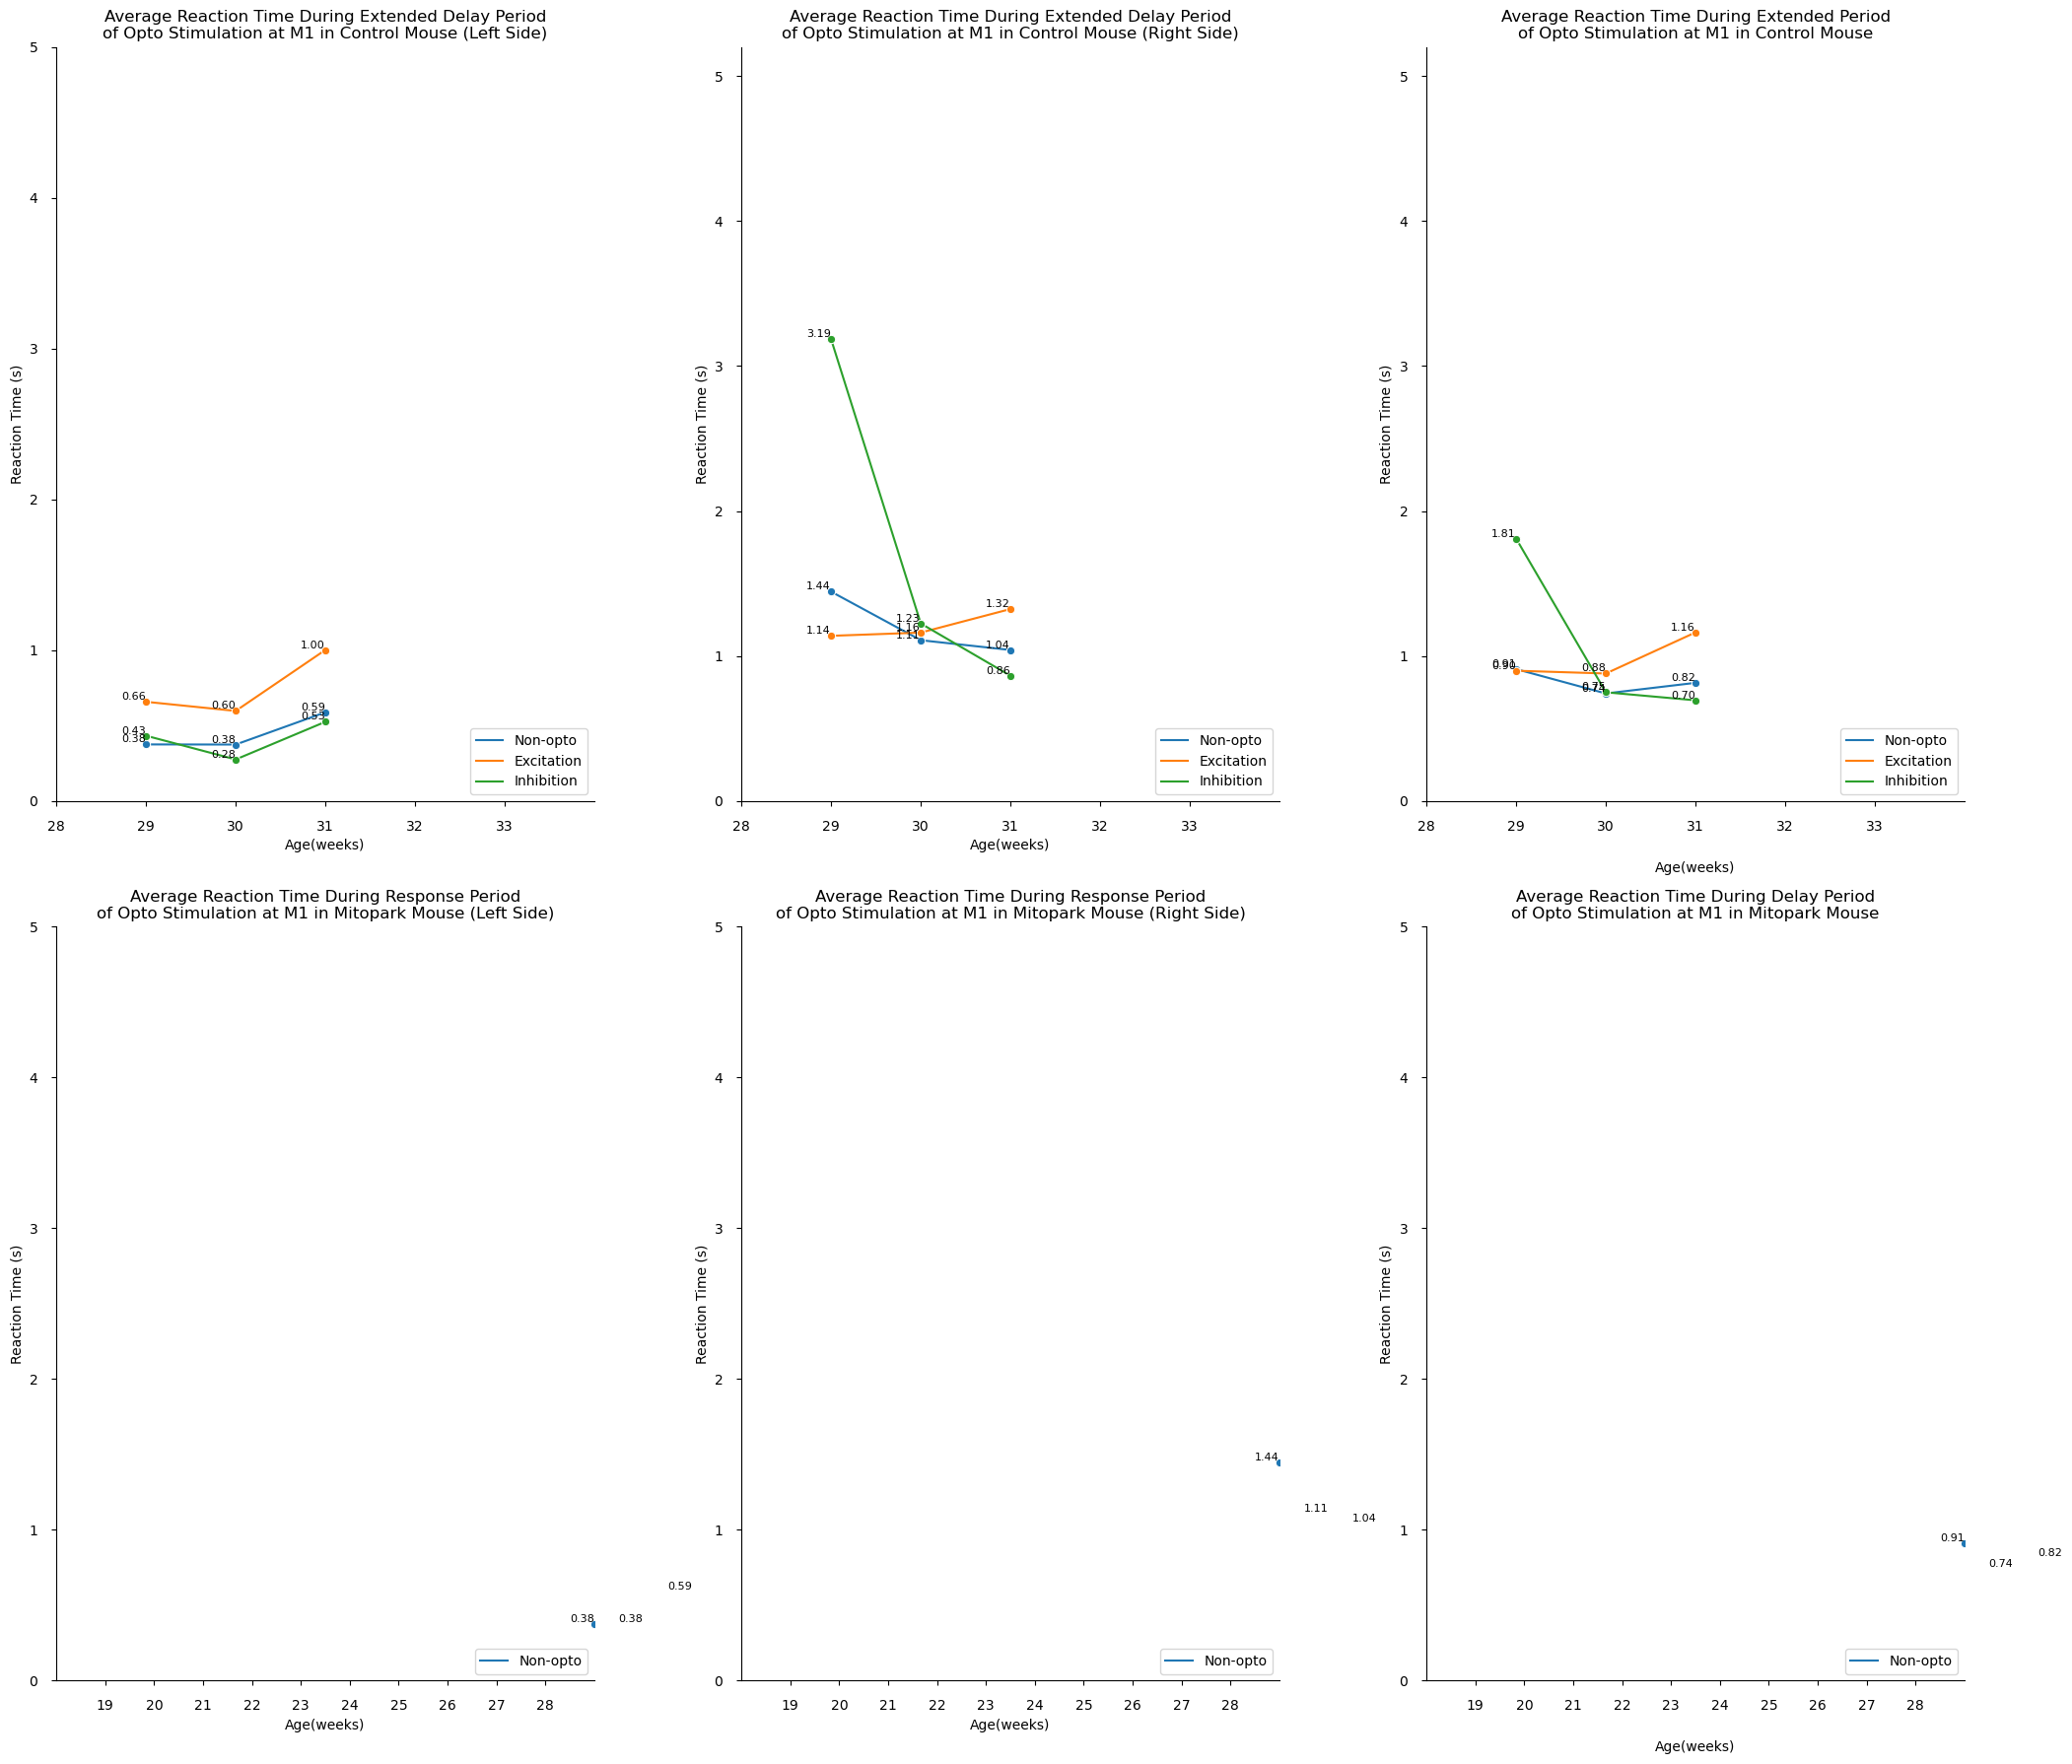

In [31]:
# Set figures to be 2x2
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(21, 18)

# Plotting the first line plot: RT mean of opto during delay period, M1, by OptoEI, Left (ax[0][0])
sns.lineplot(data=success_trials_M1[
    ((success_trials_M1.IDOptoLoc == "Opto during Delay Period") & (success_trials_M1.TrialTypes == "Left Side Trials") | (success_trials_M1.IDOptoLoc == "Non-opto")) &
    (success_trials_M1.TrialTypes == "Left Side Trials")
], hue="OptoEI", x="Week_Age", y="RT mean", ci=None, marker='o', ax=ax[0][0])

for line in ax[0][0].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[0][0].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[0][0])
ax[0][0].set_title('Average Reaction Time During Extended Delay Period\nof Opto Stimulation at M1 in Control Mouse (Left Side)')
ax[0][0].set_xlabel('Age(weeks)')
ax[0][0].set_xlim(28, 34)  # Modify x-axis range
ax[0][0].set_xticks(range(28, 34))  # Add ticks for each integer value from 19 to 29
ax[0][0].set_ylabel('Reaction Time (s)')
ax[0][0].set_xlim(28, 34)  # Modify x-axis range
ax[0][0].legend(loc='lower right')
ax[0][0].set_ylim(0, 5)
ax[0][0].tick_params(axis='both', which='major', pad=10)


# Plotting the second line plot: RT mean of opto during delay period, M1, by OptoEI, Right (ax[0][1])
sns.lineplot(data=success_trials_M1[
    ((success_trials_M1.IDOptoLoc == "Opto during Delay Period") & (success_trials_M1.TrialTypes == "Right Side Trials") | (success_trials_M1.IDOptoLoc == "Non-opto")) &
    (success_trials_M1.TrialTypes == "Right Side Trials")
], hue="OptoEI", x="Week_Age", y="RT mean", ci=None, marker='o', ax=ax[0][1])

# Annotate y-values for the 2nd subplot
for line in ax[0][1].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[0][1].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

# Remove upper and right borders for the 2nd subplot
sns.despine(ax=ax[0][1])
ax[0][1].set_title('Average Reaction Time During Extended Delay Period\nof Opto Stimulation at M1 in Control Mouse (Right Side)')
ax[0][1].set_xlabel('Age(weeks)')
ax[0][1].set_xlim(28, 34)  # Modify x-axis range
ax[0][1].set_xticks(range(28, 34))  # Add ticks for each integer value from 19 to 29
ax[0][1].set_ylabel('Reaction Time (s)')
ax[0][1].set_xlim(28, 34)  # Modify x-axis range
ax[0][1].legend(loc='lower right')
ax[0][1].set_ylim(0, 5.2)
ax[0][1].tick_params(axis='both', which='major', pad=10)


# Plotting the third（0，2） line plot: RT of opto during delay period, M1, by OptoEI, both L&R
sns.lineplot(data=success_trials_M1[
    ((success_trials_M1.IDOptoLoc == "Opto during Delay Period") | (success_trials_M1.IDOptoLoc == "Non-opto"))
], hue="OptoEI", x="Week_Age", y="RT mean", ci=None, marker='o', ax=ax[0][2])

for line in ax[0][2].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[0][2].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[0][2])
ax[0][2].set_title('Average Reaction Time During Extended Period\nof Opto Stimulation at M1 in Control Mouse')
ax[0][2].set_xlabel('Age(weeks)', labelpad=20)
ax[0][2].set_xlim(28, 34)  # Modify x-axis range
ax[0][2].set_xticks(range(28, 34))  # Add ticks for each integer value from 19 to 29
ax[0][2].set_ylabel('Reaction Time (s)')
ax[0][2].set_xlim(28, 34)  # Modify x-axis range
ax[0][2].legend(loc='lower right')
ax[0][2].set_ylim(0, 5.2)
ax[0][2].tick_params(axis='both', which='major', pad=10)


# Plotting the fourth line plot: Average Reaction Time of opto during response period, M1, by OptoEI, Left (ax[1][0])
sns.lineplot(data=success_trials_M1[
    ((success_trials_M1.IDOptoLoc == "Opto during Response Period") & (success_trials_M1.TrialTypes == "Left Side Trials") | (success_trials_M1.IDOptoLoc == "Non-opto")) &
    (success_trials_M1.TrialTypes == "Left Side Trials")
], hue="OptoEI", x="Week_Age", y="RT mean", ci=None, marker='o', ax=ax[1][0])

for line in ax[1][0].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[1][0].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[1][0])
ax[1][0].set_title('Average Reaction Time During Response Period\nof Opto Stimulation at M1 in Mitopark Mouse (Left Side)')
ax[1][0].set_xlabel('Age(weeks)')
ax[1][0].set_xlim(18, 29)  # Modify x-axis range
ax[1][0].set_xticks(range(19, 29))  # Add ticks for each integer value from 19 to 29
ax[1][0].set_ylabel('Reaction Time (s)')
ax[1][0].set_xlim(18, 29)  # Modify x-axis range
ax[1][0].legend(loc='lower right')
ax[1][0].set_ylim(0, 5)
ax[1][0].tick_params(axis='both', which='major', pad=10)


# Plotting the fifth line plot: Average Reaction Time of opto during response period, M1, by OptoEI, Right (ax[0][1])
sns.lineplot(data=success_trials_M1[
    ((success_trials_M1.IDOptoLoc == "Opto during Response Period") & (success_trials_M1.TrialTypes == "Right Side Trials") | (success_trials_M1.IDOptoLoc == "Non-opto")) &
    (success_trials_M1.TrialTypes == "Right Side Trials")
], hue="OptoEI", x="Week_Age", y="RT mean", ci=None, marker='o', ax=ax[1][1])

for line in ax[1][1].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[1][1].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[1][1])
ax[1][1].set_title('Average Reaction Time During Response Period\nof Opto Stimulation at M1 in Mitopark Mouse (Right Side)')
ax[1][1].set_xlabel('Age(weeks)')
ax[1][1].set_xlim(18, 29)  # Modify x-axis range
ax[1][1].set_xticks(range(19, 29))  # Add ticks for each integer value from 19 to 29
ax[1][1].set_ylabel('Reaction Time (s)')
ax[1][1].set_xlim(18, 29)  # Modify x-axis range
ax[1][1].legend(loc='lower right')
ax[1][1].set_ylim(0, 5)
ax[1][1].tick_params(axis='both', which='major', pad=10)


# 6th subplot
sns.lineplot(data=success_trials_M1[
    ((success_trials_M1.IDOptoLoc == "Opto during Response Period") | (success_trials_M1.IDOptoLoc == "Non-opto"))
], hue="OptoEI", x="Week_Age", y="RT mean", ci=None, marker='o', ax=ax[1][2])

for line in ax[1][2].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[1][2].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[1][2])
ax[1][2].set_title('Average Reaction Time During Delay Period\nof Opto Stimulation at M1 in Mitopark Mouse')
ax[1][2].set_xlabel('Age(weeks)', labelpad=20)
ax[1][2].set_xlim(18, 29)  # Modify x-axis range
ax[1][2].set_xticks(range(19, 29))  # Add ticks for each integer value from 19 to 29
ax[1][2].set_ylabel('Reaction Time (s)')
ax[1][2].set_xlim(18, 29)  # Modify x-axis range
ax[1][2].legend(loc='lower right')
ax[1][2].set_ylim(0, 5)
ax[1][2].tick_params(axis='both', which='major', pad=10)

plt.tight_layout()  # Adjust layout to prevent overlapping titles
plt.show()


## Reaction Time M2

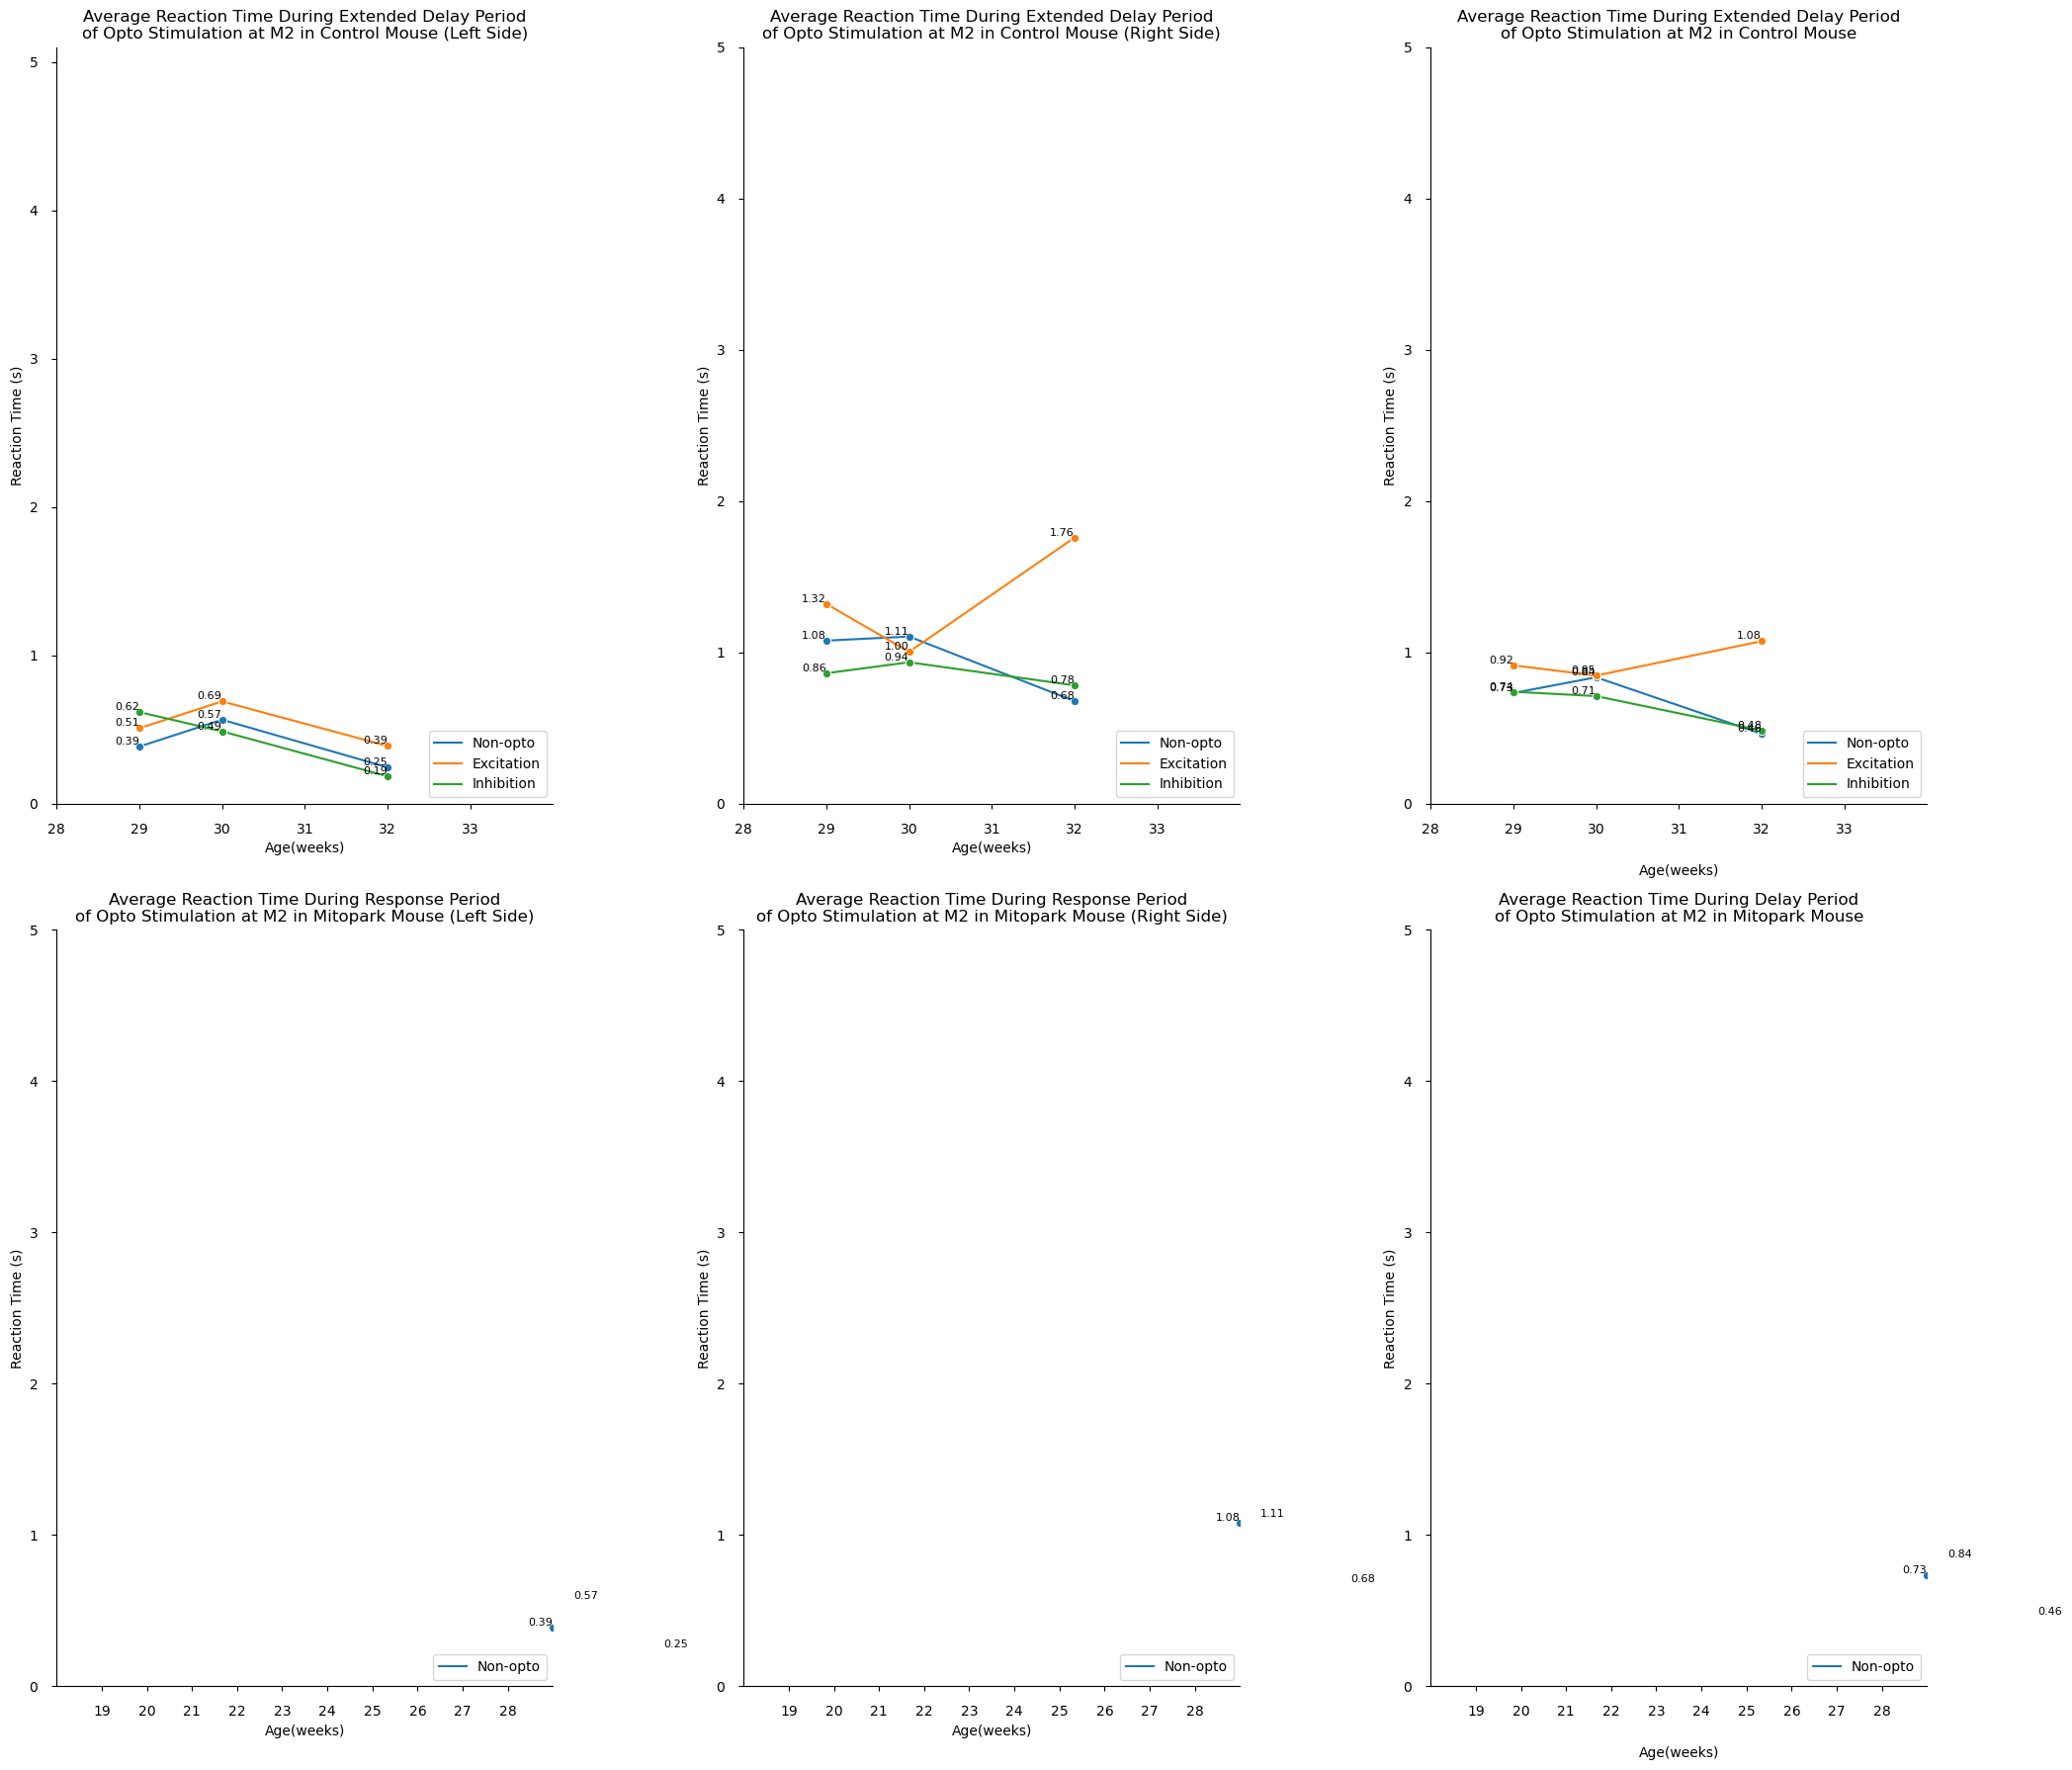

In [32]:
# Set figures to be 2x2
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(21, 18)

# Plotting the first line plot: RT mean of opto during delay period, M2, by OptoEI, Left (ax[0][0])
sns.lineplot(data=success_trials_M2[
    ((success_trials_M2.IDOptoLoc == "Opto during Delay Period") & (success_trials_M2.TrialTypes == "Left Side Trials") | (success_trials_M2.IDOptoLoc == "Non-opto")) &
    (success_trials_M2.TrialTypes == "Left Side Trials")
], hue="OptoEI", x="Week_Age", y="RT mean", ci=None, marker='o', ax=ax[0][0])

for line in ax[0][0].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[0][0].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[0][0])
ax[0][0].set_title('Average Reaction Time During Extended Delay Period\nof Opto Stimulation at M2 in Control Mouse (Left Side)')
ax[0][0].set_xlabel('Age(weeks)')
ax[0][0].set_xlim(28,34)  # Modify x-axis range
ax[0][0].set_xticks(range(28,34))  # Add ticks for each integer value from 19 to 29
ax[0][0].set_ylabel('Reaction Time (s)')
ax[0][0].set_xlim(28,34)  # Modify x-axis range
ax[0][0].legend(loc='lower right')
ax[0][0].set_ylim(0, 5.1)
ax[0][0].tick_params(axis='both', which='major', pad=10)


# Plotting the second line plot: RT mean of opto during delay period, M1, by OptoEI, Right (ax[0][1])
sns.lineplot(data=success_trials_M2[
    ((success_trials_M2.IDOptoLoc == "Opto during Delay Period") & (success_trials_M2.TrialTypes == "Right Side Trials") | (success_trials_M2.IDOptoLoc == "Non-opto")) &
    (success_trials_M2.TrialTypes == "Right Side Trials")
], hue="OptoEI", x="Week_Age", y="RT mean", ci=None, marker='o', ax=ax[0][1])

# Annotate y-values for the 2nd subplot
for line in ax[0][1].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[0][1].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

# Remove upper and right borders for the 2nd subplot
sns.despine(ax=ax[0][1])
ax[0][1].set_title('Average Reaction Time During Extended Delay Period\nof Opto Stimulation at M2 in Control Mouse (Right Side)')
ax[0][1].set_xlabel('Age(weeks)')
ax[0][1].set_xlim(28,34)  # Modify x-axis range
ax[0][1].set_xticks(range(28,34))  # Add ticks for each integer value from 19 to 29
ax[0][1].set_ylabel('Reaction Time (s)')
ax[0][1].set_xlim(28,34)  # Modify x-axis range
ax[0][1].legend(loc='lower right')
ax[0][1].set_ylim(0, 5)
ax[0][1].tick_params(axis='both', which='major', pad=10)


# Plotting the third（0，2） line plot: RT of opto during delay period, M1, by OptoEI, both L&R
sns.lineplot(data=success_trials_M2[
    ((success_trials_M2.IDOptoLoc == "Opto during Delay Period") | (success_trials_M2.IDOptoLoc == "Non-opto"))
], hue="OptoEI", x="Week_Age", y="RT mean", ci=None, marker='o', ax=ax[0][2])

for line in ax[0][2].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[0][2].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[0][2])
ax[0][2].set_title('Average Reaction Time During Extended Delay Period\nof Opto Stimulation at M2 in Control Mouse')
ax[0][2].set_xlabel('Age(weeks)', labelpad=20)
ax[0][2].set_xlim(28,34)  # Modify x-axis range
ax[0][2].set_xticks(range(28,34))  # Add ticks for each integer value from 19 to 29
ax[0][2].set_ylabel('Reaction Time (s)')
ax[0][2].set_xlim(28,34)  # Modify x-axis range
ax[0][2].legend(loc='lower right')
ax[0][2].set_ylim(0, 5)
ax[0][2].tick_params(axis='both', which='major', pad=10)


# Plotting the fourth line plot: Average Reaction Time of opto during response period, M1, by OptoEI, Left (ax[1][0])
sns.lineplot(data=success_trials_M2[
    ((success_trials_M2.IDOptoLoc == "Opto during Response Period") & (success_trials_M2.TrialTypes == "Left Side Trials") | (success_trials_M2.IDOptoLoc == "Non-opto")) &
    (success_trials_M2.TrialTypes == "Left Side Trials")
], hue="OptoEI", x="Week_Age", y="RT mean", ci=None, marker='o', ax=ax[1][0])

for line in ax[1][0].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[1][0].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[1][0])
ax[1][0].set_title('Average Reaction Time During Response Period\nof Opto Stimulation at M2 in Mitopark Mouse (Left Side)')
ax[1][0].set_xlabel('Age(weeks)')
ax[1][0].set_xlim(18, 29)  # Modify x-axis range
ax[1][0].set_xticks(range(19, 29))  # Add ticks for each integer value from 19 to 29
ax[1][0].set_ylabel('Reaction Time (s)')
ax[1][0].set_xlim(18, 29)  # Modify x-axis range
ax[1][0].legend(loc='lower right')
ax[1][0].set_ylim(0, 5)
ax[1][0].tick_params(axis='both', which='major', pad=10)


# Plotting the fifth line plot: Average Reaction Time of opto during response period, M1, by OptoEI, Right (ax[0][1])
sns.lineplot(data=success_trials_M2[
    ((success_trials_M2.IDOptoLoc == "Opto during Response Period") & (success_trials_M2.TrialTypes == "Right Side Trials") | (success_trials_M2.IDOptoLoc == "Non-opto")) &
    (success_trials_M2.TrialTypes == "Right Side Trials")
], hue="OptoEI", x="Week_Age", y="RT mean", ci=None, marker='o', ax=ax[1][1])

for line in ax[1][1].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[1][1].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[1][1])
ax[1][1].set_title('Average Reaction Time During Response Period\nof Opto Stimulation at M2 in Mitopark Mouse (Right Side)')
ax[1][1].set_xlabel('Age(weeks)')
ax[1][1].set_xlim(18, 29)  # Modify x-axis range
ax[1][1].set_xticks(range(19, 29))  # Add ticks for each integer value from 19 to 29
ax[1][1].set_ylabel('Reaction Time (s)')
ax[1][1].set_xlim(18, 29)  # Modify x-axis range
ax[1][1].legend(loc='lower right')
ax[1][1].set_ylim(0, 5)
ax[1][1].tick_params(axis='both', which='major', pad=10)


# 6th subplot
sns.lineplot(data=success_trials_M2[
    ((success_trials_M2.IDOptoLoc == "Opto during Response Period") | (success_trials_M2.IDOptoLoc == "Non-opto"))
], hue="OptoEI", x="Week_Age", y="RT mean", ci=None, marker='o', ax=ax[1][2])

for line in ax[1][2].lines:
    y_values = line.get_ydata()
    x_values = line.get_xdata()
    for i in range(len(x_values)):
        ax[1][2].text(x_values[i], y_values[i], f"{y_values[i]:.2f}", va='bottom', ha='right', fontsize=8)

sns.despine(ax=ax[1][2])
ax[1][2].set_title('Average Reaction Time During Delay Period\nof Opto Stimulation at M2 in Mitopark Mouse')
ax[1][2].set_xlabel('Age(weeks)', labelpad=20)
ax[1][2].set_xlim(18, 29)  # Modify x-axis range
ax[1][2].set_xticks(range(19, 29))  # Add ticks for each integer value from 19 to 29
ax[1][2].set_ylabel('Reaction Time (s)')
ax[1][2].set_xlim(18, 29)  # Modify x-axis range
ax[1][2].legend(loc='lower right')
ax[1][2].set_ylim(0, 5)
ax[1][2].tick_params(axis='both', which='major', pad=10)

plt.tight_layout()  # Adjust layout to prevent overlapping titles
plt.show()


# Reaction Time Significance 

In [33]:
# Initialize lists to store results
significant_results = []
other_results = []

# Iterate over unique values of Week_Age, TrialTypes, and IDOptoLoc
for Week_Age_value in df.Week_Age.unique():
    for TrialTypes_value in df.TrialTypes.unique():
        for Location_value in df.Location.unique():
            for IDOptoLoc_value in df.IDOptoLoc.unique():
                # Skip if IDOptoLoc is "Opto in Consumption Period"
                if IDOptoLoc_value == "Opto in Consumption Period":
                    continue
                
                # Filter the DataFrame based on current values of Week_Age, TrialTypes, Location, and IDOptoLoc
                tmp = df[((df.IDOptoLoc == IDOptoLoc_value) & (df.TrialTypes == TrialTypes_value) | (df.IDOptoLoc == "Non-opto")) &
                         (df.TrialTypes == TrialTypes_value) & (df.Location == Location_value)]
                
                # Select relevant columns and drop NaN values
                tmp2 = tmp[['OptoEI', 'Week_Age', 'RT']].dropna()
                
                # Check if the data subsets for 'Non-opto', 'Inhibition', and 'Excitation' are empty
                if tmp2[(tmp2.OptoEI == 'Non-opto') & (tmp2.Week_Age == Week_Age_value)].empty \
                        or tmp2[(tmp2.OptoEI == 'Inhibition') & (tmp2.Week_Age == Week_Age_value)].empty \
                        or tmp2[(tmp2.OptoEI == 'Excitation') & (tmp2.Week_Age == Week_Age_value)].empty:
                    print(f"No data available for Week_Age {Week_Age_value}, TrialTypes {TrialTypes_value}, Location {Location_value}, IDOptoLoc {IDOptoLoc_value}")
                    continue
                
                # Perform Mann-Whitney U test for OptoEI categories 'Non-opto' and 'Inhibition'
                result_inhibition = mannwhitneyu(tmp2.loc[(tmp2.OptoEI == 'Non-opto') & (tmp2.Week_Age == Week_Age_value), 'RT'],
                                                  tmp2.loc[(tmp2.OptoEI == 'Inhibition') & (tmp2.Week_Age == Week_Age_value), 'RT'])
                
                # Perform Mann-Whitney U test for OptoEI categories 'Non-opto' and 'Excitation'
                result_excitation = mannwhitneyu(tmp2.loc[(tmp2.OptoEI == 'Non-opto') & (tmp2.Week_Age == Week_Age_value), 'RT'],
                                                  tmp2.loc[(tmp2.OptoEI == 'Excitation') & (tmp2.Week_Age == Week_Age_value), 'RT'])
                
                # Store results in respective lists based on p-value
                if result_inhibition.pvalue < 0.05 or result_excitation.pvalue < 0.05:
                    significant_results.append((Week_Age_value, TrialTypes_value, Location_value, IDOptoLoc_value, 
                                                result_inhibition.statistic, result_inhibition.pvalue, 
                                                result_excitation.statistic, result_excitation.pvalue))
                    print(f"Significant result for Week_Age {Week_Age_value}, TrialTypes {TrialTypes_value}, Location {Location_value}, IDOptoLoc {IDOptoLoc_value}:")
                    print(f"Mann-Whitney U test for OptoEI categories 'Non-opto' and 'Inhibition': U = {result_inhibition.statistic}, p-value = {result_inhibition.pvalue}")
                    print(f"Mann-Whitney U test for OptoEI categories 'Non-opto' and 'Excitation': U = {result_excitation.statistic}, p-value = {result_excitation.pvalue}")
                    print()
                else:
                    other_results.append((Week_Age_value, TrialTypes_value, Location_value, IDOptoLoc_value, 
                                          result_inhibition.statistic, result_inhibition.pvalue, 
                                          result_excitation.statistic, result_excitation.pvalue))

# Create DataFrames from the lists
significant_df = pd.DataFrame(significant_results, columns=['Week_Age', 'TrialTypes', 'Location', 'IDOptoLoc', 
                                                            'Inhibition_Statistic', 'Inhibition_p-value', 
                                                            'Excitation_Statistic', 'Excitation_p-value'])
other_df = pd.DataFrame(other_results, columns=['Week_Age', 'TrialTypes', 'Location', 'IDOptoLoc', 
                                                'Inhibition_Statistic', 'Inhibition_p-value', 
                                                'Excitation_Statistic', 'Excitation_p-value'])

# Export DataFrames to separate sheets in an Excel file
with pd.ExcelWriter('mann_whitney_u_results_AP36_one_opto.xlsx') as writer:
    significant_df.to_excel(writer, sheet_name='Significant_Results', index=False)
    other_df.to_excel(writer, sheet_name='Other_Results', index=False)

print (significant_df)

Significant result for Week_Age 29, TrialTypes Left Side Trials, Location M2, IDOptoLoc Opto during Delay Period:
Mann-Whitney U test for OptoEI categories 'Non-opto' and 'Inhibition': U = 368.0, p-value = 0.5945660460528879
Mann-Whitney U test for OptoEI categories 'Non-opto' and 'Excitation': U = 198.0, p-value = 0.01294565930184885

Significant result for Week_Age 29, TrialTypes Left Side Trials, Location M1, IDOptoLoc Opto during Delay Period:
Mann-Whitney U test for OptoEI categories 'Non-opto' and 'Inhibition': U = 178.0, p-value = 0.7193334730776582
Mann-Whitney U test for OptoEI categories 'Non-opto' and 'Excitation': U = 69.0, p-value = 0.002400323858777044

Significant result for Week_Age 30, TrialTypes Left Side Trials, Location M2, IDOptoLoc Opto during Delay Period:
Mann-Whitney U test for OptoEI categories 'Non-opto' and 'Inhibition': U = 627.0, p-value = 0.1821535317758215
Mann-Whitney U test for OptoEI categories 'Non-opto' and 'Excitation': U = 284.0, p-value = 0.02198

In [49]:
RT_data_M1 = df[(df.IDOptoLoc == "Non-opto") | \
                          ((df.Location == "M1") & \
                           (df.IDOptoLoc == "Opto during Delay Period"))]

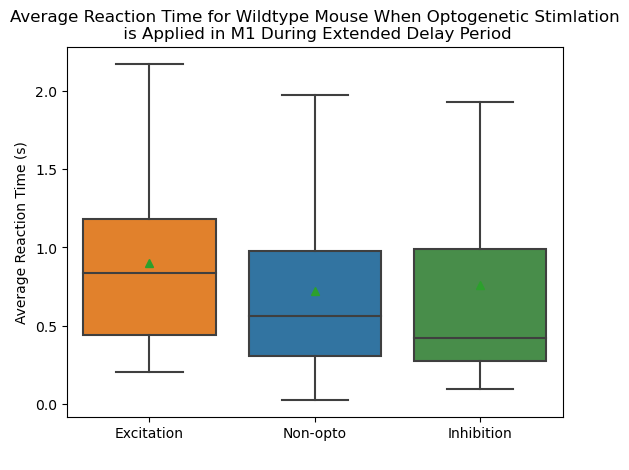

In [53]:
sns.boxplot(data=RT_data_M1[RT_data_M1.Outcome == 'Correct'], y='RT', x='OptoEI', showfliers=False, showmeans=True,palette={"Non-opto": "#1f77b4","Excitation": "#Ff7f0e", "Inhibition": "#3d983f"},order = ['Excitation', 'Non-opto', 'Inhibition'])
plt.title('Average Reaction Time for Wildtype Mouse When Optogenetic Stimlation\n is Applied in M1 During Extended Delay Period')
plt.xlabel(' ')
plt.ylabel('Average Reaction Time (s)')

plt.show()

In [52]:
mannwhitneyu(RT_data_M1.loc[(RT_data_M1.OptoEI== 'Non-opto') & (RT_data_M1.Outcome == 'Correct'),'RT'],\
             RT_data_M1.loc[(RT_data_M1.OptoEI== 'Excitation') & (RT_data_M1.Outcome == 'Correct'),'RT'])


MannwhitneyuResult(statistic=6409.5, pvalue=0.0022338912456639336)

In [54]:
mannwhitneyu(RT_data_M1.loc[(RT_data_M1.OptoEI== 'Non-opto') & (RT_data_M1.Outcome == 'Correct'),'RT'],\
             RT_data_M1.loc[(RT_data_M1.OptoEI== 'Inhibition') & (RT_data_M1.Outcome == 'Correct'),'RT'])

MannwhitneyuResult(statistic=11482.5, pvalue=0.2605602376118109)

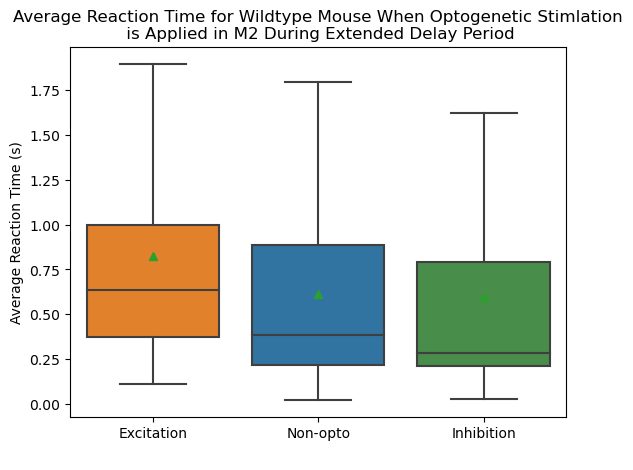

In [60]:
sns.boxplot(data=RT_data_M2[RT_data_M2.Outcome == 'Correct'], y='RT', x='OptoEI', showfliers=False, showmeans=True,palette={"Non-opto": "#1f77b4","Excitation": "#Ff7f0e", "Inhibition": "#3d983f"},order = ['Excitation', 'Non-opto', 'Inhibition'])
plt.title('Average Reaction Time for Wildtype Mouse When Optogenetic Stimlation\n is Applied in M2 During Extended Delay Period')
plt.xlabel(' ')
plt.ylabel('Average Reaction Time (s)')

plt.show()

In [57]:
RT_data_M2 = df[(df.IDOptoLoc == "Non-opto") | \
                          ((df.Location == "M2") & \
                           (df.IDOptoLoc == "Opto during Delay Period"))]

In [58]:
mannwhitneyu(RT_data_M2.loc[(RT_data_M2.OptoEI== 'Non-opto') & (RT_data_M2.Outcome == 'Correct'),'RT'],\
             RT_data_M2.loc[(RT_data_M2.OptoEI== 'Excitation') & (RT_data_M2.Outcome == 'Correct'),'RT'])


MannwhitneyuResult(statistic=6738.0, pvalue=0.0011212048156911995)

In [59]:
mannwhitneyu(RT_data_M2.loc[(RT_data_M2.OptoEI== 'Non-opto') & (RT_data_M2.Outcome == 'Correct'),'RT'],\
             RT_data_M2.loc[(RT_data_M2.OptoEI== 'Inhibition') & (RT_data_M2.Outcome == 'Correct'),'RT'])


MannwhitneyuResult(statistic=10371.0, pvalue=0.4572043923146918)

# Chi-square on success rate 

In [43]:
delay_data = all_outcomes[(all_outcomes.IDOptoLoc == "Non-opto") | \
                          ((all_outcomes.Location == "M1") & \
                           (all_outcomes.IDOptoLoc == "Opto during Delay Period"))]

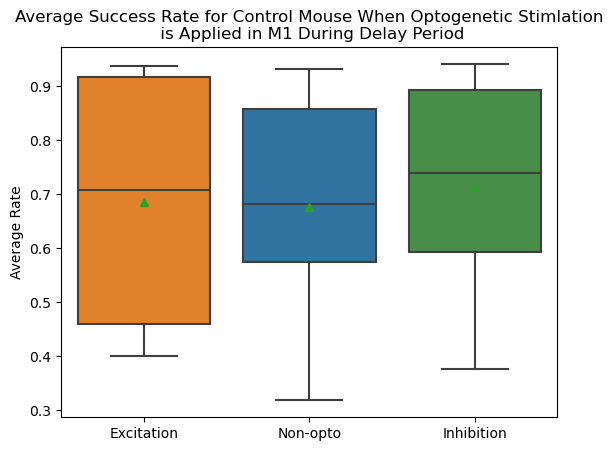

In [45]:
sns.boxplot(data=delay_data[delay_data.Outcome == 'Correct'], y='Average Rate', x='OptoEI', showfliers=False, showmeans=True,palette={"Non-opto": "#1f77b4","Excitation": "#Ff7f0e", "Inhibition": "#3d983f"},order = ['Excitation', 'Non-opto', 'Inhibition'])
plt.title('Average Success Rate for Control Mouse When Optogenetic Stimlation\n is Applied in M1 During Delay Period')
plt.xlabel(' ')
plt.ylabel('Average Rate')
plt.show()

In [62]:
delay_data_M2 = all_outcomes[(all_outcomes.IDOptoLoc == "Non-opto") | \
                          ((all_outcomes.Location == "M2") & \
                           (all_outcomes.IDOptoLoc == "Opto during Delay Period"))]

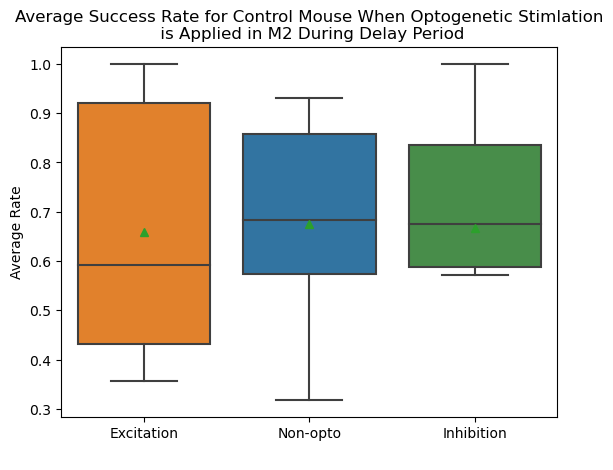

In [66]:
sns.boxplot(data=delay_data_M2[delay_data_M2.Outcome == 'Correct'], y='Average Rate', x='OptoEI', showfliers=False, showmeans=True,palette={"Non-opto": "#1f77b4","Excitation": "#Ff7f0e", "Inhibition": "#3d983f"},order = ['Excitation', 'Non-opto', 'Inhibition'])
plt.title('Average Success Rate for Control Mouse When Optogenetic Stimlation\n is Applied in M2 During Delay Period')
plt.xlabel(' ')
plt.ylabel('Average Rate')
plt.show()

In [67]:
mannwhitneyu(delay_data.loc[(delay_data.OptoEI== 'Non-opto') & (delay_data.Outcome == 'Correct'),'Average Rate'],\
             delay_data.loc[(delay_data.OptoEI== 'Excitation') & (delay_data.Outcome == 'Correct'),'Average Rate'])

MannwhitneyuResult(statistic=36.0, pvalue=1.0)

In [68]:
mannwhitneyu(delay_data_M2.loc[(delay_data_M2.OptoEI== 'Non-opto') & (delay_data_M2.Outcome == 'Correct'),'Average Rate'],\
             delay_data_M2.loc[(delay_data_M2.OptoEI== 'Excitation') & (delay_data_M2.Outcome == 'Correct'),'Average Rate'])


MannwhitneyuResult(statistic=36.0, pvalue=1.0)

In [34]:
# Left side, Delay period,M1

In [35]:
left_delay = success_trials_M1[
    ((success_trials_M1.IDOptoLoc == "Opto during Delay Period") & \
     (success_trials_M1.TrialTypes == "Left Side Trials") | (success_trials_M1.IDOptoLoc == "Non-opto")) & \
    (success_trials_M1.TrialTypes == "Left Side Trials")]

ct = []

columns = left_delay.OptoEI.unique()

for oei in columns:
    ct.append(left_delay.loc[left_delay.OptoEI == oei, ['Week_Age', 'Average Rate']].set_index('Week_Age'))
    
ct = pd.concat(ct, axis=1)
ct.columns = columns

ct.head()

print (ct.head())

print (chi2_contingency(ct[['Non-opto', 'Excitation']].dropna().to_numpy() + 1e-6))
print (chi2_contingency(ct[['Non-opto', 'Inhibition']].dropna().to_numpy() + 1e-6))

          Non-opto  Excitation  Inhibition
Week_Age                                  
29        0.891892    0.916667    0.909091
30        0.893617    0.937500    0.941176
31        0.818182    0.916667    0.842105
(0.0017856335824441376, 0.9991075816511018, 2, array([[0.87615805, 0.93240251],
       [0.88708651, 0.94403251],
       [0.84044917, 0.89440131]]))
(0.0002568521396080918, 0.9998715821764707, 2, array([[0.88541379, 0.91557101],
       [0.90203605, 0.93275944],
       [0.81624389, 0.84404519]]))


In [36]:
#left, delay, M2

In [37]:
left_delay_M2 = success_trials_M2[
    ((success_trials_M2.IDOptoLoc == "Opto during Delay Period") & \
     (success_trials_M2.TrialTypes == "Left Side Trials") | (success_trials_M2.IDOptoLoc == "Non-opto")) & \
    (success_trials_M2.TrialTypes == "Left Side Trials")]

ct = []

columns = left_delay.OptoEI.unique()

for oei in columns:
    ct.append(left_delay_M2.loc[left_delay_M2.OptoEI == oei, ['Week_Age', 'Average Rate']].set_index('Week_Age'))
    
ct = pd.concat(ct, axis=1)
ct.columns = columns

ct.head()

print (ct.head())

print (chi2_contingency(ct[['Non-opto', 'Excitation']].dropna().to_numpy() + 1e-6))
print (chi2_contingency(ct[['Non-opto', 'Inhibition']].dropna().to_numpy() + 1e-6))

          Non-opto  Excitation  Inhibition
Week_Age                                  
29        0.931507    1.000000    1.000000
30        0.623932    0.684211    0.636364
32        0.847222    1.000000    0.875000
(0.0022658558136865515, 0.9988677136136894, 2, array([[0.91230159, 1.01920726],
       [0.61787032, 0.69027383],
       [0.87249178, 0.97473244]]))
(0.0005951751365091228, 0.9997024567065338, 2, array([[0.94439103, 0.98711781],
       [0.61620915, 0.64408811],
       [0.84206351, 0.88016072]]))


In [38]:
# delay, right side, M1

In [39]:
right_delay = success_trials_M1[
    ((success_trials_M1.IDOptoLoc == "Opto during Delay Period") & \
     (success_trials_M1.TrialTypes == "Right Side Trials") | (success_trials_M1.IDOptoLoc == "Non-opto")) & \
    (success_trials_M1.TrialTypes == "Right Side Trials")]

ct = []

columns = right_delay.OptoEI.unique()

for oei in columns:
    ct.append(right_delay.loc[right_delay.OptoEI == oei, ['Week_Age', 'Average Rate']].set_index('Week_Age'))
    
ct = pd.concat(ct, axis=1)
ct.columns = columns

ct.head()

print (ct.head())

print (chi2_contingency(ct[['Non-opto', 'Excitation']].dropna().to_numpy() + 1e-6))
print (chi2_contingency(ct[['Non-opto', 'Inhibition']].dropna().to_numpy() + 1e-6))

          Non-opto  Excitation  Inhibition
Week_Age                                  
29        0.318182    0.500000    0.375000
30        0.740741    0.444444    0.636364
31        0.600000    0.400000    0.578947
(0.12289675770783574, 0.9404014890891303, 2, array([[0.45192723, 0.36625659],
       [0.65464307, 0.53054412],
       [0.55235526, 0.44764674]]))
(0.011500678960002007, 0.9942661620770639, 2, array([[0.35391061, 0.33927321],
       [0.70309281, 0.67401357],
       [0.60192214, 0.57702723]]))


In [40]:
#delay, right side, M2

In [41]:
right_delay_M2 = success_trials_M2[
    ((success_trials_M2.IDOptoLoc == "Opto during Delay Period") & \
     (success_trials_M2.TrialTypes == "Right Side Trials") | (success_trials_M2.IDOptoLoc == "Non-opto")) & \
    (success_trials_M2.TrialTypes == "Right Side Trials")]

ct = []

columns = right_delay_M2.OptoEI.unique()

for oei in columns:
    ct.append(right_delay_M2.loc[right_delay_M2.OptoEI == oei, ['Week_Age', 'Average Rate']].set_index('Week_Age'))
    
ct = pd.concat(ct, axis=1)
ct.columns = columns

ct.head()

print (ct.head())

print (chi2_contingency(ct[['Non-opto', 'Excitation']].dropna().to_numpy() + 1e-6))
print (chi2_contingency(ct[['Non-opto', 'Inhibition']].dropna().to_numpy() + 1e-6))

          Non-opto  Excitation  Inhibition
Week_Age                                  
29        0.596774    0.500000    0.714286
30        0.505376    0.409091    0.571429
32        0.344828    0.357143    0.200000
(0.006882972248515738, 0.9965644290015605, 2, array([[0.58491965, 0.51185655],
       [0.48769388, 0.42677538],
       [0.3743676 , 0.32760484]]))
(0.052580211930635654, 0.974052470183808, 2, array([[0.64687246, 0.66418945],
       [0.53129203, 0.54551489],
       [0.26881664, 0.27601295]]))
